In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

#import pingouin as pg
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

from matplotlib import ticker

%matplotlib inline 

from platform import python_version
print(python_version())

3.11.0


# MarketScan PRCCSR Counts

In [2]:
df_census = pd.read_csv('msa_census_2019.csv')
df_census.columns

Index(['Unnamed: 0', 'MSA', 'EGEOLOC', 'Total Pop', 'Square Miles',
       'frac_female', 'frac_white', 'frac_black', 'frac_hispanic',
       'frac_asian', 'frac_other', 'frac_under_18', 'frac_18_to_39',
       'frac_40_to_64', 'frac_over_65', 'frac_lt_20k', 'frac_20k_to_40k',
       'frac_40k_to_75k', 'frac_75k_to_125k', 'frac_125k_to_200k',
       'frac_gt_200k', 'frac_unemployed', 'frac_no_health_insurance',
       'frac_lt_hs', 'frac_hs', 'frac_some_college', 'frac_college',
       'frac_graduate', 'frac_houses_owner_occupied', 'median_house_price',
       'pop_density', 'State Name', 'Name'],
      dtype='object')

In [3]:
xls = pd.ExcelFile('MS_2019_procedure_counts_final.xlsx')
xls.sheet_names

['procedure_counts_18_64',
 'procedure_counts_0_17',
 'memdays_18_64',
 'memdays_0_17']

In [4]:
#df_counts = pd.read_excel('MarketScan_PCCRS_Inpatient_Counts_2019.xlsx')
#df_memdays = pd.read_excel(xls, 'mem_days')

df_counts = pd.read_excel(xls, 'procedure_counts_18_64')
df_memdays = pd.read_excel(xls, 'memdays_18_64')

In [5]:
for procedure in df_counts.PRCCSR.drop_duplicates():
    df_temp = df_counts[df_counts.PRCCSR == procedure].reset_index()
    proc_name = df_temp.PRCCSR_DESCRIPTION[0]
    df_memdays = pd.merge(df_memdays, df_temp[['MSA', 'EGEOLOC', 'num']], how='left', on=['MSA', 'EGEOLOC']).rename(columns={'num': proc_name})
    df_memdays[proc_name] = df_memdays[proc_name].fillna(0)/df_memdays.mem_days*36500

In [6]:
df_memdays

,MSA,EGEOLOC,mem_days,Colectomy,ENT repair,Episiotomy,Frenectomy,Skin graft,Thymectomy,Gastrectomy,...,Perineal muscle laceration repair (2nd degree obstetrical and other),Heart valve replacement and other valve procedures (non-endovascular),"Lower GI therapeutic procedures, NEC (excluding open and laparoscopic)",Placement of tunneled or implantable portion of a vascular access device,Peripheral nerve decompression (excluding lumbosacral and cervicothoracic),Angioplasty and related vessel procedures (endovascular; excluding carotid),"ENT excision (excluding nasal passage, sinuses, tongue, salivary glands, larynx)","Administration and transfusion of bone marrow, stem cells, pancreatic islet cells, and t-cells","Embolectomy, endarterectomy, and related vessel procedures (non-endovascular; excluding carotid)",Overall Inpatient Visits
0,30860.0,1,434629,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.083980,...,0.503878,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,4.870821
1,26820.0,1,787584,0.000000,0.0,0.139033,0.0,0.046344,0.0,0.000000,...,0.741508,0.000000,0.0,0.046344,0.0,0.046344,0.0,0.0,0.0,5.839377
2,21780.0,1,482950,0.000000,0.0,0.151154,0.0,0.000000,0.0,0.075577,...,0.226732,0.000000,0.0,0.000000,0.0,0.075577,0.0,0.0,0.0,6.650792
3,23580.0,1,406427,0.359228,0.0,0.089807,0.0,0.000000,0.0,0.000000,...,0.538842,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,3.771895
4,14260.0,1,4082579,0.080464,0.0,0.035762,0.0,0.000000,0.0,0.026821,...,0.286094,0.017881,0.0,0.008940,0.0,0.008940,0.0,0.0,0.0,5.766575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,41980.0,97,133358,0.000000,0.0,0.547399,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,6.568785
561,41900.0,97,3771,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
562,38660.0,97,13146,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2.776510
563,NaN,97,365,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000


In [7]:
(df_memdays['Overall Inpatient Visits']*df_memdays['mem_days']).sum()/100 #/ df_memdays['mem_days'].sum()

280040410.0

In [8]:
(df_memdays['Overall Inpatient Visits']*df_memdays['mem_days']).sum() / df_memdays['mem_days'].sum()

5.405663148420936

In [9]:
df = pd.merge(df_census, df_memdays, on=['MSA', 'EGEOLOC'])
procedures = df.columns[34:]

In [10]:
df.columns[0:30]

Index(['Unnamed: 0', 'MSA', 'EGEOLOC', 'Total Pop', 'Square Miles',
       'frac_female', 'frac_white', 'frac_black', 'frac_hispanic',
       'frac_asian', 'frac_other', 'frac_under_18', 'frac_18_to_39',
       'frac_40_to_64', 'frac_over_65', 'frac_lt_20k', 'frac_20k_to_40k',
       'frac_40k_to_75k', 'frac_75k_to_125k', 'frac_125k_to_200k',
       'frac_gt_200k', 'frac_unemployed', 'frac_no_health_insurance',
       'frac_lt_hs', 'frac_hs', 'frac_some_college', 'frac_college',
       'frac_graduate', 'frac_houses_owner_occupied', 'median_house_price'],
      dtype='object')

In [11]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

In [13]:
#this code does partial correlations controling for state

df_procs = pd.DataFrame([])
df_procs['procedure'] = procedures
temp = []
for pp in procedures:
    temp = temp + [(df[pp] * df.mem_days).sum() / df.mem_days.sum()]
df_procs['rate'] = temp

features = ['frac_white', 'frac_lt_40k', 'frac_college_plus', 'frac_40_to_64', 'median_house_price']

for feature in features:
    df_procs['corr_' + feature] = -999.

for proc in procedures:
    df_temp = df[[proc, 'State Name', 'mem_days', 'frac_white', 'frac_40_to_64', 'frac_lt_20k', 'frac_20k_to_40k', 'frac_college','frac_graduate', 'median_house_price']].copy()
    df_temp['frac_lt_40k'] = df_temp.frac_lt_20k + df_temp.frac_20k_to_40k
    df_temp['frac_college_plus'] = df_temp.frac_college + df_temp.frac_graduate
    df_temp['phat'] = df_temp[proc].clip(lower = np.percentile(df_temp[df_temp[proc]>0][proc], 5),
                                     upper = np.percentile(df_temp[df_temp[proc]>0][proc], 95))
    df_temp['weight'] = df_temp['mem_days']/df_temp['phat']
    
    for feature in features:
        X = sm.add_constant(pd.get_dummies(df_temp['State Name']).iloc[:,:-1]).astype(int)
        y = df_temp[proc]
        weight = df_temp['weight']

        est = sm.WLS(y, X, weights=weight).fit() 
        resid_Optum = est.resid

        y = df_temp[feature]

        est = sm.WLS(y, X, weights = weight).fit() 
        resid_feature = est.resid

        df_procs.loc[df_procs.procedure == proc, 'corr_' + feature] = corr(resid_feature, resid_Optum, weight)

In [14]:
df_procs.sort_values(by='rate', ascending=False)#.to_csv('2019_MS_procedure_rates2.csv')#[0:20]

,procedure,rate,corr_frac_white,corr_frac_lt_40k,corr_frac_college_plus,corr_frac_40_to_64,corr_median_house_price
295,Overall Inpatient Visits,5.401322,0.049143,0.311385,-0.495667,-0.067508,-0.283116
122,Spontaneous vaginal delivery,0.863466,-0.188582,-0.277425,0.365936,-0.207333,0.314000
43,Cesarean section,0.469317,-0.426032,-0.249126,0.288920,0.038019,0.263848
92,Assisted vaginal delivery,0.396079,-0.061121,-0.211658,0.252989,0.011826,0.301314
286,Perineal muscle laceration repair (2nd degree ...,0.306903,-0.175925,-0.453363,0.589204,-0.002661,0.477244
...,...,...,...,...,...,...,...
154,"Peripheral nerve procedures, NEC",0.000850,-0.176692,-0.108675,0.121763,0.082787,0.181109
218,Spleen procedures (excluding splenectomy),0.000850,-0.146517,-0.131345,0.106214,0.138622,0.091973
102,Speech therapy evaluation,0.000825,-0.203097,-0.010239,0.024301,-0.014394,0.093318
98,"Lymphatic procedures, NEC",0.000785,-0.186608,-0.206018,0.163936,0.150542,0.172503


In [15]:
df_procs = pd.DataFrame([])
df_procs['procedure'] = procedures
temp = []
for pp in procedures:
    temp = temp + [(df[pp] * df.mem_days).sum() / df.mem_days.sum()]
df_procs['rate'] = temp

features = ['frac_white', 'frac_lt_40k', 'frac_college_plus']

for feature in features:
    df_procs['corr_' + feature] = -999.

for proc in procedures:
    df_temp = df[[proc, 'State Name', 'mem_days', 'frac_white', 'frac_40_to_64', 'frac_lt_20k', 'frac_20k_to_40k', 'frac_college','frac_graduate']].copy()
    df_temp['frac_lt_40k'] = df_temp.frac_lt_20k + df_temp.frac_20k_to_40k
    df_temp['frac_college_plus'] = df_temp.frac_college + df_temp.frac_graduate
    df_temp['phat'] = df_temp[proc].clip(lower = np.percentile(df_temp[df_temp[proc]>0][proc], 5),
                                     upper = np.percentile(df_temp[df_temp[proc]>0][proc], 95))
    df_temp['weight'] =  df_temp['mem_days']/df_temp['phat']
    
    for feature in features:
        df_procs.loc[df_procs.procedure == proc, 'corr_' + feature] = corr(df_temp[proc], df_temp[feature], df_temp['weight'])

In [16]:
df_procs.sort_values(by='rate', ascending=False)[0:20]

,procedure,rate,corr_frac_white,corr_frac_lt_40k,corr_frac_college_plus
295,Overall Inpatient Visits,5.401322,0.191529,0.474918,-0.494739
122,Spontaneous vaginal delivery,0.863466,-0.012665,-0.227007,0.242542
43,Cesarean section,0.469317,-0.398564,-0.056922,0.114501
92,Assisted vaginal delivery,0.396079,0.146185,-0.113350,0.115719
286,Perineal muscle laceration repair (2nd degree ...,0.306903,-0.069591,-0.477949,0.529023
136,Intravenous induction of labor,0.247837,0.152549,0.017927,0.005081
112,Fetal heart rate monitoring,0.206744,-0.089949,-0.068014,0.088919
200,Venous and arterial catheter placement,0.194811,-0.095244,0.356803,-0.340473
266,Perineal skin repair (1st degree obstetrical a...,0.187088,-0.170850,-0.322424,0.306378
224,Measurement during cardiac catheterization,0.138450,0.099742,0.501643,-0.473952


# Read in SID data

In [17]:
df_pccrs = pd.read_excel('PRCCSR_classification.xlsx')

In [18]:
df_pccrs

,ICD-10-PCS,ICD-10-PCS DESCRIPTION,PRCCSR,PRCCSR DESCRIPTION,CLINICAL DOMAIN
0,0016070,Bypass Cerebral Ventricle to Nasopharynx with ...,CNS010,Cerebrospinal fluid shunt procedures,Central Nervous System Procedures
1,0016071,Bypass Cerebral Ventricle to Mastoid Sinus wit...,CNS010,Cerebrospinal fluid shunt procedures,Central Nervous System Procedures
2,0016072,Bypass Cerebral Ventricle to Atrium with Autol...,CNS010,Cerebrospinal fluid shunt procedures,Central Nervous System Procedures
3,0016073,Bypass Cerebral Ventricle to Blood Vessel with...,CNS010,Cerebrospinal fluid shunt procedures,Central Nervous System Procedures
4,0016074,Bypass Cerebral Ventricle to Pleural Cavity wi...,CNS010,Cerebrospinal fluid shunt procedures,Central Nervous System Procedures
...,...,...,...,...,...
81592,XXE97U7,"Measurement of Infection, Nasopharyngeal Fluid...",MAM015,"Measurement and monitoring, NEC",Measurement and Monitoring
81593,XXEBXQ6,"Measurement of Infection, Lower Respiratory Fl...",MAM014,Pulmonary function tests,Measurement and Monitoring
81594,XY0VX83,Extracorporeal Introduction of Endothelial Dam...,ADM021,"Administration of therapeutic substances, NEC",Administration of Therapeutic Substances
81595,XY0YX28,Extracorporeal Introduction of Taurolidine Ant...,ADM021,"Administration of therapeutic substances, NEC",Administration of Therapeutic Substances


In [91]:
states = ['IA', 'NJ', 'MD', 'CA', 'MI']
state_names = ['Iowa', 'New Jersey', 'Maryland', 'California', 'Michigan']

cols = ['ZIP', 'PRCCSR', 'row_num']
df_counts = pd.DataFrame([], columns = cols)

for state in states:
    print(state)
    df_temp = pd.read_csv('SID Data -- 2019/SID_' + state + '_2019_Full.csv', low_memory=False)
    proc_cols = [i for i, s in enumerate(df_temp.columns) if 'I10_PR' in s]
    loc_cols = [i for i, s in enumerate(df_temp.columns) if 'ZIP' in s]
    df_temp = df_temp[(pd.to_numeric(df_temp['AGE'], errors='coerce') <= 64)
                     &(pd.to_numeric(df_temp['AGE'], errors='coerce') >= 18)].iloc[:, proc_cols + loc_cols].copy()
    df_temp['row_num'] = df_temp.index
    
    df_procs = pd.DataFrame([], columns = cols)
    for proc_col in [s for i, s in enumerate(df_temp.columns) if 'I10_PR' in s and 'PROCTYPE' not in s]:
        df_tt = pd.merge(df_temp[[proc_col, 'ZIP', 'row_num']], df_pccrs, left_on = proc_col, right_on = 'ICD-10-PCS')
        df_procs = pd.concat([df_procs, df_tt[cols]])
    df_counts = pd.concat([df_counts, df_procs.groupby(['ZIP', 'PRCCSR']).row_num.nunique().reset_index().rename(columns={'row_num':'count'})])

    df_tot_hosps = pd.DataFrame(df_temp.groupby('ZIP').size()).rename(columns={0:'count'}).reset_index()
    df_tot_hosps['PRCCSR'] = 'XXX'
    df_tot_hosps['row_num'] = np.nan
    df_counts = pd.concat([df_counts, df_tot_hosps])
    
df_counts = df_counts.groupby(['ZIP', 'PRCCSR'])['count'].sum().reset_index()

IA


/var/folders/kd/5z7n_h8j5cq1f4ybg56gdyph0000gq/T/ipykernel_79181/2921912038.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_procs = pd.concat([df_procs, df_tt[cols]])
/var/folders/kd/5z7n_h8j5cq1f4ybg56gdyph0000gq/T/ipykernel_79181/2921912038.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_counts = pd.concat([df_counts, df_procs.groupby(['ZIP', 'PRCCSR']).row_num.nunique().reset_index().rename(columns={'row_num':'count'})])


In [93]:
df_temp = pd.read_csv('SID Data -- 2019/SID_' + 'IA' + '_2019_Full.csv', low_memory=False)

In [95]:
list(df_temp.columns)

['AGE',
 'AGEDAY',
 'AGEMONTH',
 'AMONTH',
 'ATYPE',
 'AWEEKEND',
 'BWT',
 'DIED',
 'DISPUB04',
 'DISPUNIFORM',
 'DISP_X',
 'DMONTH',
 'DQTR',
 'DRG',
 'DRGVER',
 'DRG_NoPOA',
 'DXPOA1',
 'DXPOA2',
 'DXPOA3',
 'DXPOA4',
 'DXPOA5',
 'DXPOA6',
 'DXPOA7',
 'DXPOA8',
 'DXPOA9',
 'DXPOA10',
 'DXPOA11',
 'DXPOA12',
 'DXPOA13',
 'DXPOA14',
 'DXPOA15',
 'DXPOA16',
 'DXPOA17',
 'DXPOA18',
 'DXPOA19',
 'DXPOA20',
 'DXPOA21',
 'DXPOA22',
 'DXPOA23',
 'DXPOA24',
 'DXPOA25',
 'DXPOA26',
 'DXPOA27',
 'DXPOA28',
 'DXPOA29',
 'DXPOA30',
 'DXPOA31',
 'DXPOA32',
 'DXPOA33',
 'DXPOA34',
 'DXPOA35',
 'DXPOA36',
 'DXPOA37',
 'DXPOA38',
 'DXPOA39',
 'DXPOA40',
 'DXPOA41',
 'DXPOA42',
 'DXPOA43',
 'DXPOA44',
 'DXPOA45',
 'DXPOA46',
 'DXPOA47',
 'DXPOA48',
 'DXPOA49',
 'DXPOA50',
 'DXPOA51',
 'DXPOA52',
 'DXPOA53',
 'DXPOA54',
 'DXPOA55',
 'DXPOA56',
 'DXPOA57',
 'DXPOA58',
 'DXPOA59',
 'DXPOA60',
 'DXPOA61',
 'DXPOA62',
 'DXPOA63',
 'DXPOA64',
 'DaysToEvent',
 'FEMALE',
 'HCUP_ED',
 'HCUP_OS',
 'HISPANIC',
 

In [109]:
df_temp.groupby('P7EDSRC_X').size()

P7EDSRC_X
P7    149447
dtype: int64

In [24]:
df_tt = pd.merge(df_counts, df_pccrs[['PRCCSR', 'PRCCSR DESCRIPTION']].drop_duplicates(), on='PRCCSR', how='left')
df_tt.loc[df_tt.PRCCSR == 'XXX', 'PRCCSR DESCRIPTION'] = 'Overall Inpatient Visits'
df_tt['ZIP'] = pd.to_numeric(df_tt['ZIP'], errors='coerce')
df_tt = df_tt[~df_tt.ZIP.isna()].copy()
df_tt['ZIP'] = df_tt['ZIP'].astype(int)
df_tt.to_csv('SID_zip_counts.csv')

In [25]:
df_crosswalk = pd.read_excel('ZIP_COUNTY_122019.xlsx')

df_counts['ZIP'] = pd.to_numeric(df_counts['ZIP'], errors='coerce')
df_counts = df_counts[~df_counts.ZIP.isna()].copy()
df_counts['ZIP'] = df_counts['ZIP'].astype(int)

df_tt = pd.merge(df_counts, df_crosswalk, on='ZIP')
df_tt['count_adjusted'] = df_tt['count'] * df_tt['RES_RATIO']

In [26]:
df_sid_county = pd.DataFrame(df_tt.groupby(['COUNTY', 'PRCCSR'])['count_adjusted'].sum()).rename(columns={'count_adjusted': 'count'}).reset_index()
df_sid_county['FIPS State Code'] = np.floor(df_sid_county['COUNTY']/1000).astype(int)
df_sid_county['FIPS County Code'] = np.mod(df_sid_county['COUNTY'],1000).astype(int)

In [27]:
df_msa_x = pd.read_csv('crosswalk_after_2014.csv')

df_stage = pd.merge(df_msa_x, df_sid_county[['FIPS State Code', 'FIPS County Code', 'PRCCSR', 'count']],
        how='left', on = ['FIPS State Code', 'FIPS County Code'])
df_sid_counts = df_stage.groupby(['MSA', 'EGEOLOC', 'State Name', 'PRCCSR'])['count'].sum().reset_index()

In [28]:
df_sid_counts = df_sid_counts[df_sid_counts['State Name'].isin(state_names)].copy()
df_sid_counts = pd.merge(df_sid_counts, df_pccrs[['PRCCSR', 'PRCCSR DESCRIPTION']].drop_duplicates(), on='PRCCSR', how='left')
df_sid_counts.loc[df_sid_counts['PRCCSR'] == 'XXX', 'PRCCSR DESCRIPTION'] = 'Overall Inpatient Visits'
df_sid_counts.to_csv('sid_2019_msa_counts.csv')

# compare SID to MarketScan

In [20]:
df_sid_counts = pd.read_csv('sid_2019_msa_counts.csv')

In [21]:
df_sid_counts[df_sid_counts['PRCCSR DESCRIPTION'] == 'Cesarean section'].groupby('State Name')['count'].sum()

State Name
California    129087.0
Iowa            9944.0
Maryland       19996.0
Michigan       32842.0
New Jersey     30066.0
Name: count, dtype: float64

In [22]:
df_temp = df[['MSA', 'EGEOLOC']].copy()
df_temp['Pop 18 to 65'] = df['Total Pop'] * (1 - df['frac_over_65'] - df['frac_under_18'])

df_temp = pd.merge(df_temp, 
                  df_sid_counts[df_sid_counts['PRCCSR DESCRIPTION'].isin(procedures)],
                  on=['MSA', 'EGEOLOC'])
df_sid = df_temp[['MSA', 'EGEOLOC', 'State Name', 'Pop 18 to 65']].drop_duplicates()

for proc in procedures:
    df_sid = pd.merge(df_sid, 
                      df_temp[df_temp['PRCCSR DESCRIPTION'] == proc][['MSA', 'EGEOLOC', 'count']], 
                      on=['MSA', 'EGEOLOC'], 
                      how='left')
    df_sid['count'] = df_sid['count'].fillna(0) / df_sid['Pop 18 to 65'] * 100
    df_sid.rename(columns={'count': proc}, inplace=True)

In [23]:
df_sid

,MSA,EGEOLOC,State Name,Pop 18 to 65,Colectomy,ENT repair,Episiotomy,Frenectomy,Skin graft,Thymectomy,...,Perineal muscle laceration repair (2nd degree obstetrical and other),Heart valve replacement and other valve procedures (non-endovascular),"Lower GI therapeutic procedures, NEC (excluding open and laparoscopic)",Placement of tunneled or implantable portion of a vascular access device,Peripheral nerve decompression (excluding lumbosacral and cervicothoracic),Angioplasty and related vessel procedures (endovascular; excluding carotid),"ENT excision (excluding nasal passage, sinuses, tongue, salivary glands, larynx)","Administration and transfusion of bone marrow, stem cells, pancreatic islet cells, and t-cells","Embolectomy, endarterectomy, and related vessel procedures (non-endovascular; excluding carotid)",Overall Inpatient Visits
0,32900,62,California,160967.0,0.066221,0.011120,0.074505,0.000000e+00,0.024169,0.001862,...,0.286287,0.017618,0.003152,0.061850,0.005629,0.043100,0.002534,0.003139,0.005036,8.931548
1,0,62,California,489097.0,0.071921,0.013204,0.043256,3.755435e-07,0.028016,0.001021,...,0.263309,0.020728,0.002825,0.046707,0.006026,0.035480,0.002658,0.006105,0.015077,7.554703
2,36084,62,California,1793867.0,0.045323,0.010871,0.026370,0.000000e+00,0.018062,0.001617,...,0.436901,0.016389,0.002453,0.039022,0.003902,0.028988,0.002453,0.005073,0.008251,5.844036
3,33700,62,California,325892.0,0.065882,0.014757,0.043847,0.000000e+00,0.020170,0.001228,...,0.417352,0.027190,0.003325,0.077778,0.004883,0.054715,0.003970,0.004589,0.007946,9.101149
4,42200,62,California,279082.0,0.052241,0.008938,0.058607,0.000000e+00,0.010362,0.001072,...,0.324507,0.011499,0.002143,0.041072,0.003939,0.035045,0.003221,0.002865,0.006086,6.353126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,45940,11,New Jersey,234277.0,0.062679,0.012856,0.040792,0.000000e+00,0.014766,0.000427,...,0.327530,0.012930,0.002978,0.046401,0.002983,0.045275,0.002437,0.002927,0.008694,7.703858
71,47220,11,New Jersey,93057.0,0.081989,0.009317,0.027522,0.000000e+00,0.044815,0.001034,...,0.242895,0.019306,0.006065,0.089910,0.006214,0.067096,0.001103,0.002108,0.026145,10.426213
72,12100,11,New Jersey,162363.0,0.065596,0.011515,0.055103,0.000000e+00,0.012636,0.001114,...,0.177890,0.012703,0.003820,0.072743,0.006322,0.047734,0.002887,0.001275,0.017687,10.340659
73,48864,11,New Jersey,37808.0,0.094716,0.008351,0.030897,0.000000e+00,0.020865,0.000101,...,0.185393,0.018930,0.010574,0.061934,0.005380,0.023310,0.005219,0.000101,0.021648,9.084439


In [24]:
(df_sid['Overall Inpatient Visits']*df_sid['Pop 18 to 65']).sum()/100 #/ df_memdays['mem_days'].sum()

3127092.0

In [25]:
(df_sid['Overall Inpatient Visits']*df_sid['Pop 18 to 65']).sum() / df_sid['Pop 18 to 65'].sum()

7.434343153858465

In [26]:
#for each procedure, estimate the rate in MS and SID

df_procs = pd.DataFrame([], columns = ['procedure', 'rate_MS', 'err_rate_MS', 'rate_SID', 'err_rate_SID', 'rel_bias', 'rel_bias_low', 'rel_bias_high'])
ii = 0
for proc in procedures:
    df_temp = pd.merge(df_sid[['MSA', 'EGEOLOC', 'Pop 18 to 65', proc]], df[['MSA', 'EGEOLOC', proc, 'Total Pop', 'mem_days']], on=['MSA', 'EGEOLOC'], how='outer').rename(columns = {proc+'_x': 'sid', proc+'_y': 'ms'}).fillna(0)
    rate_ms = (df_temp.ms * df_temp.mem_days).sum() / df_temp.mem_days.sum()
    rate_sid = (df_temp.sid * df_temp['Pop 18 to 65']).sum() / df_temp['Pop 18 to 65'].sum()
    rel_bias = rate_ms / rate_sid
    err_rate_ms = (rate_ms / df_temp.mem_days.sum() * 36500) ** 0.5
    err_rate_sid = (rate_sid / df_temp['Pop 18 to 65'].sum()) ** 0.5
    err_log_rel_bias = ((err_rate_ms / rate_ms)**2 + (err_rate_sid / rate_sid)**2) ** 0.5
    df_procs.loc[ii] = [proc, rate_ms, err_rate_ms, rate_sid, err_rate_sid, rel_bias, np.exp(np.log(rel_bias) - 1.96 * err_log_rel_bias), np.exp(np.log(rel_bias) + 1.96 * err_log_rel_bias)]
    ii += 1

In [27]:
df_procs

,procedure,rate_MS,err_rate_MS,rate_SID,err_rate_SID,rel_bias,rel_bias_low,rel_bias_high
0,Colectomy,0.067844,0.000745,0.060595,3.795507e-05,1.119626,1.095758,1.144012
1,ENT repair,0.005190,0.000206,0.010427,1.574477e-05,0.497718,0.460447,0.538006
2,Episiotomy,0.050476,0.000642,0.059749,3.768907e-05,0.844809,0.823974,0.866170
3,Frenectomy,0.001013,0.000091,0.000029,8.235549e-07,35.523732,29.527360,42.737838
4,Skin graft,0.010265,0.000290,0.020952,2.231844e-05,0.489941,0.463563,0.517821
...,...,...,...,...,...,...,...,...
291,Angioplasty and related vessel procedures (end...,0.019746,0.000402,0.034237,2.852977e-05,0.576743,0.554179,0.600226
292,"ENT excision (excluding nasal passage, sinuses...",0.002550,0.000144,0.003155,8.660389e-06,0.808280,0.723293,0.903252
293,"Administration and transfusion of bone marrow,...",0.006448,0.000230,0.005463,1.139664e-05,1.180335,1.100649,1.265789
294,"Embolectomy, endarterectomy, and related vesse...",0.007307,0.000244,0.011402,1.646423e-05,0.640821,0.600124,0.684277


In [28]:
df_procs.sort_values(by = 'rate_SID', ascending=False)[1:251].rel_bias.describe()

count    250.000000
mean       0.672091
std        0.249313
min        0.109457
25%        0.501282
50%        0.652230
75%        0.830355
max        1.456287
Name: rel_bias, dtype: float64

In [29]:
np.percentile(df_procs.sort_values(by = 'rate_SID', ascending=False)[1:251].rel_bias, 95)

1.0991210454900318

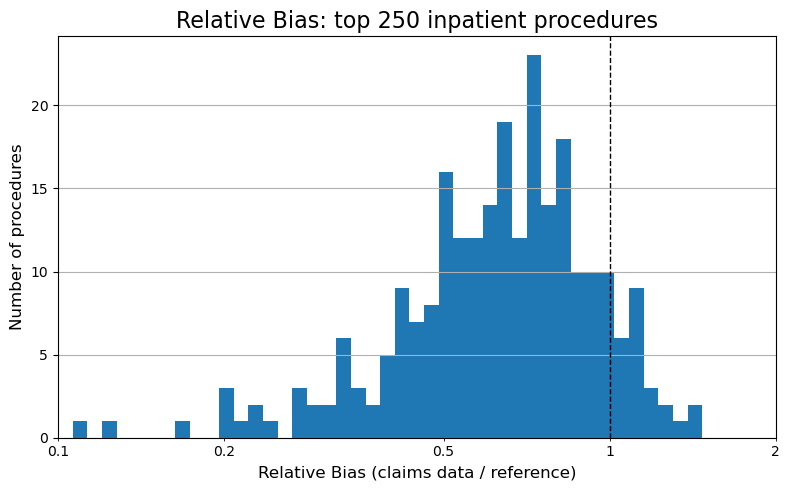

In [30]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

weights = np.ones(250) #/ 2.5
df_procs.sort_values(by = 'rate_SID', ascending=False)[1:251].rel_bias.hist(
    weights=weights,
    bins=np.logspace(np.log10(0.1),np.log10(2.0), 50),
    ax=ax)

plt.xscale('log')

plt.xlabel('Relative Bias (claims data / reference)', fontsize=12)
plt.ylabel('Number of procedures', fontsize=12)

plt.title('Relative Bias: top 250 inpatient procedures', fontsize=16)

#plt.gca().set_xscale("log")
plt.axvline(1,linestyle='--', color='k', lw=1)
plt.xlim([0.1, 2])

ax = plt.gca()
locs = np.array([.1, 0.2, 0.5,  1, 2, 5, 10])
labels = np.array(['0.1', '0.2', '0.5', '1', '2', '5','10'])

ax.xaxis.set_minor_locator(ticker.FixedLocator(locs))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(labels))
ax.xaxis.set_major_locator(ticker.NullLocator())

plt.tight_layout()
plt.savefig('temp.jpg', dpi=400)

In [31]:
df_procs[df_procs.procedure == 'Overall Inpatient Visits'].rel_bias.values[0]

0.7265365523249383

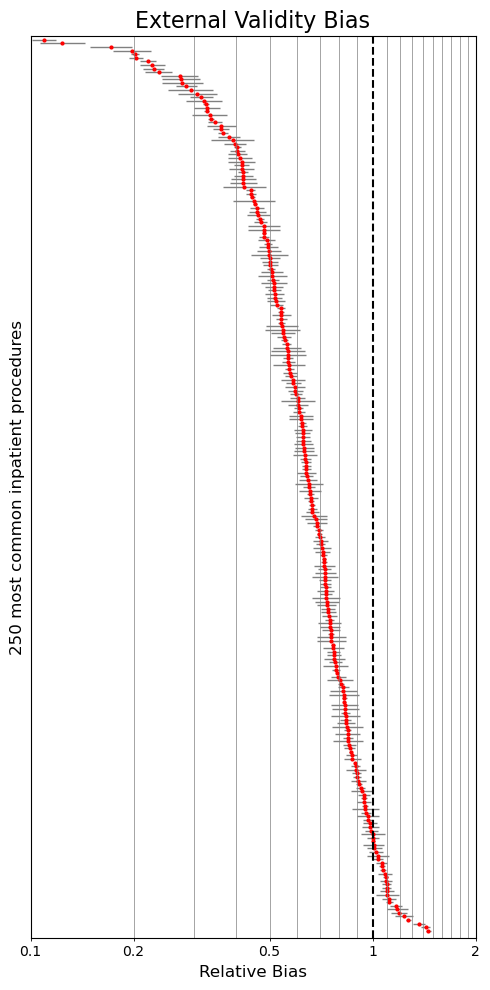

In [32]:
plt.figure(figsize=(5,10))

df_temp = df_procs.sort_values(by = 'rate_SID', ascending=False)[1:251].sort_values(by='rel_bias').copy()

err = np.array([np.array(df_temp['rel_bias']        - df_temp['rel_bias_low'])  ,
                np.array(df_temp['rel_bias_high']   - df_temp['rel_bias'])   ])

plt.scatter(df_temp['rel_bias'],df_temp['procedure'],  s=4, zorder=2,
             color='red')
plt.barh(df_temp['procedure'], df_temp['rel_bias'], xerr=err, facecolor='none', 
         error_kw=dict(lw=1, capsize=0, capthick=0, ecolor='gray'), zorder=1)


plt.xscale('log')
plt.gca().invert_yaxis()

plt.xlabel('Relative Bias', fontsize=12)
plt.ylabel('250 most common inpatient procedures', fontsize=12)

plt.title('External Validity Bias', fontsize=16)


plt.axvline(1,linestyle='--', color='k', lw=1.5)
#plt.axvline(df_procs[df_procs.procedure == 'Overall Inpatient Visits'].rel_bias.values[0],linestyle=':', color='gray', lw=1)
plt.axvline(.2, color='gray', linewidth=0.5)
plt.axvline(.3, color='gray', linewidth=0.5)
plt.axvline(.4, color='gray', linewidth=0.5)
plt.axvline(.5, color='gray', linewidth=0.5)
plt.axvline(.6, color='gray', linewidth=0.5)
plt.axvline(.7, color='gray', linewidth=0.5)
plt.axvline(.8, color='gray', linewidth=0.5)
plt.axvline(.9, color='gray', linewidth=0.5)
plt.axvline(1.1, color='gray', linewidth=0.5)
plt.axvline(1.2, color='gray', linewidth=0.5)
plt.axvline(1.3, color='gray', linewidth=0.5)
plt.axvline(1.4, color='gray', linewidth=0.5)
plt.axvline(1.5, color='gray', linewidth=0.5)
plt.axvline(1.6, color='gray', linewidth=0.5)
plt.axvline(1.7, color='gray', linewidth=0.5)
plt.axvline(1.8, color='gray', linewidth=0.5)
plt.axvline(1.9, color='gray', linewidth=0.5)
plt.axvline(2.0, color='gray', linewidth=0.5)
plt.axvline(2.1, color='gray', linewidth=0.5)
plt.axvline(2.2, color='gray', linewidth=0.5)
plt.axvline(2.3, color='gray', linewidth=0.5)
plt.axvline(2.4, color='gray', linewidth=0.5)
plt.xlim([0.1, 2])

plt.ylim([251, -1])

ax = plt.gca()
locs = np.array([.1, 0.2, 0.5,  1, 2, 5, 10])
labels = np.array(['0.1', '0.2', '0.5', '1', '2', '5','10'])

ax.xaxis.set_minor_locator(ticker.FixedLocator(locs))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(labels))
ax.xaxis.set_major_locator(ticker.NullLocator())

ax.yaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_minor_locator(ticker.NullLocator())

plt.tight_layout()
plt.savefig('temp.jpg', dpi = 400)

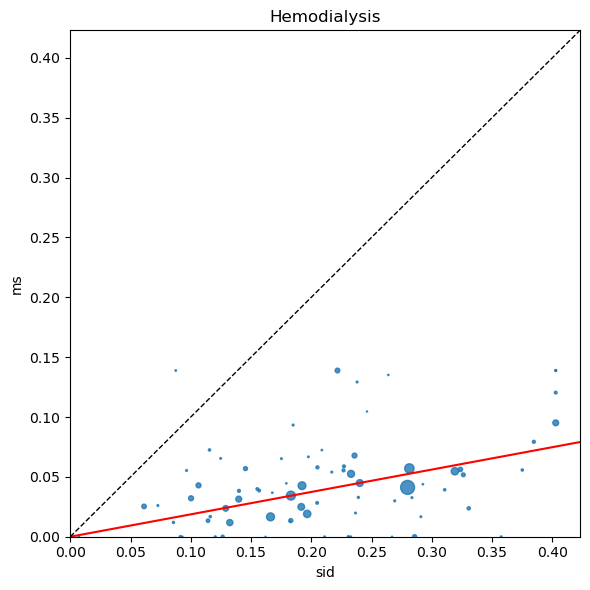

In [33]:
#make a scatter plot comparing rates for a given procedure

proc = 'Pharmacotherapy for mental health (excluding substance use)'
proc = 'Hemodialysis'
upper_clip = 95

#proc = 'Fetal heart rate monitoring'

df_temp = pd.merge(df_sid[['MSA', 'EGEOLOC', proc]], df[['MSA', 'EGEOLOC', proc, 'Total Pop']], on=['MSA', 'EGEOLOC']).rename(columns = {proc+'_x': 'sid', proc+'_y': 'ms'})


df_temp['sid'] = df_temp.sid.clip(upper = np.percentile(df_temp.sid, upper_clip))
df_temp['ms'] = df_temp.ms.clip(upper = np.percentile(df_temp.ms, upper_clip))

plot_max = max(df_temp.sid.max(), df_temp.ms.max())*1.05

plt.figure(figsize=(6,6))
plt.title(proc)
sns.regplot(x=df_temp.sid, y=df_temp.ms,  scatter_kws={'s': df_temp['Total Pop']/100000}, fit_reg=False)
plt.ylim([0,plot_max])
plt.xlim([0,plot_max])

est = sm.WLS(df_temp.ms, df_temp.sid, weights=df_temp['Total Pop']).fit()
slope = est.params['sid']
x_vals = np.array(plt.xlim())
y_vals = slope * x_vals
plt.plot(x_vals, y_vals, 'r-')


xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)

plt.tight_layout()
plt.savefig('temp.jpg')

In [34]:
df_temp.to_csv('procedure_rates_2019.csv')

# Determine zip code association between SES and procedure rate

In [37]:
df_ses = pd.read_csv('census_zip_2019_with_pca_and_ndi.csv')
df_ses

,Unnamed: 0,zip,Total Pop,Square Miles,frac_female,frac_white,frac_black,frac_hispanic,frac_asian,frac_other,...,County Code,County,State Code,State,pop_density,total_pop_millions,log_10_pop_density,house_price_millions,SES,NDI
0,0,35228,10293.143006,4.485270,0.553400,0.057527,0.857561,0.062580,0.001179,0.021153,...,73,Jefferson,1,Alabama,2294.876937,0.004781,3.036564,0.0855,-4.224270,1.263236
1,1,35214,17072.143160,33.164212,0.557357,0.206600,0.749724,0.019214,0.008430,0.016031,...,73,Jefferson,1,Alabama,514.776087,0.001946,3.352320,0.0678,-1.617630,0.551203
2,2,35204,10312.324334,4.700888,0.528552,0.048820,0.894343,0.046149,0.002804,0.007884,...,73,Jefferson,1,Alabama,2193.697256,0.004080,3.467169,0.0684,-5.228271,1.478569
3,3,35234,5439.930425,2.305478,0.553772,0.101442,0.879663,0.015966,0.001799,0.001130,...,73,Jefferson,1,Alabama,2359.566944,0.005291,3.625690,0.0641,-5.144553,1.484304
4,4,35210,14633.232997,20.925082,0.554609,0.622672,0.280717,0.052337,0.003810,0.040465,...,73,Jefferson,1,Alabama,699.315445,0.002533,3.444273,0.0673,0.540388,-0.230508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33555,33555,82215,309.387097,163.723831,0.495204,0.920264,0.000600,0.059952,0.000000,0.019185,...,31,Platte,56,Wyoming,1.889689,0.001622,1.023097,0.0813,-0.094913,-0.244544
33556,33556,82214,35.870968,18.982473,0.495204,0.920264,0.000600,0.059952,0.000000,0.019185,...,31,Platte,56,Wyoming,1.889689,0.002051,1.581576,0.0952,-0.082030,-0.244544
33557,33557,82213,941.612903,498.289919,0.495204,0.920264,0.000600,0.059952,0.000000,0.019185,...,31,Platte,56,Wyoming,1.889689,0.002312,1.093418,0.1164,-0.089438,-0.244544
33558,33558,82059,209.444344,49.801033,0.479818,0.932888,0.000000,0.042513,0.000000,0.024600,...,21,Laramie,56,Wyoming,4.205622,0.003400,1.892861,0.1083,3.699783,-0.888475


In [38]:
df_procs 

,procedure,rate_MS,err_rate_MS,rate_SID,err_rate_SID,rel_bias,rel_bias_low,rel_bias_high
0,Colectomy,0.067844,0.000745,0.060595,3.795507e-05,1.119626,1.095758,1.144012
1,ENT repair,0.005190,0.000206,0.010427,1.574477e-05,0.497718,0.460447,0.538006
2,Episiotomy,0.050476,0.000642,0.059749,3.768907e-05,0.844809,0.823974,0.866170
3,Frenectomy,0.001013,0.000091,0.000029,8.235549e-07,35.523732,29.527360,42.737838
4,Skin graft,0.010265,0.000290,0.020952,2.231844e-05,0.489941,0.463563,0.517821
...,...,...,...,...,...,...,...,...
291,Angioplasty and related vessel procedures (end...,0.019746,0.000402,0.034237,2.852977e-05,0.576743,0.554179,0.600226
292,"ENT excision (excluding nasal passage, sinuses...",0.002550,0.000144,0.003155,8.660389e-06,0.808280,0.723293,0.903252
293,"Administration and transfusion of bone marrow,...",0.006448,0.000230,0.005463,1.139664e-05,1.180335,1.100649,1.265789
294,"Embolectomy, endarterectomy, and related vesse...",0.007307,0.000244,0.011402,1.646423e-05,0.640821,0.600124,0.684277


In [39]:
procs = list(df_procs.sort_values(by = 'rate_SID', ascending=False)[1:251].procedure)

In [40]:
df_counts = pd.read_csv('SID_zip_counts.csv')

In [41]:
df_counts.ZIP.nunique()

16612

In [66]:
# You have 2 choices of which inequality measure to use.  You can use the National Deprivation Index (NDI)
# or you can use the SES metric we defined using PCA (SES).

inequality_measure = 'NDI'


df_procs_250 = pd.DataFrame([], columns=['procedure', 'rate_MS', 'err_rate_MS', 'rate_SID', 'err_rate_SID', 'rel_bias', 'rel_bias_low', 'rel_bias_high', 'corr_ses', 'intercept_ses', 'slope_ses', 'slope_ses_se', 'alpha'])

def ct_response(row):
    #“Calculate response observation for Cameron-Trivedi dispersion test”
    y = row[case_col]
    m = row['bev_mu']
    return ((y - m)**2 - y) / m

i=0
for proc in procs: 
    df_tt = pd.merge(df_ses, df_counts[df_counts['PRCCSR DESCRIPTION'] == proc], left_on='zip', right_on='ZIP', how='left')
    df_tt['Pop 18 - 64'] = df_tt['Total Pop'] * (df_tt['frac_18_to_39'] + df_tt['frac_40_to_64'])
    df_tt['sid_rate'] = df_tt['count'].fillna(0) / df_tt['Pop 18 - 64']
    
 #   df_tt['phat'] = df_tt['sid_rate'].clip(lower = np.percentile(df_tt[df_tt['sid_rate']>0]['sid_rate'], 5),
 #                                    upper = np.percentile(df_tt[df_tt['sid_rate']>0]['sid_rate'], 95))
    df_tt['weight'] =  df_tt['Pop 18 - 64'] 
    
    ses_corr = corr(df_tt['sid_rate'], df_tt[inequality_measure], df_tt['weight'])
    

    y = df_tt['count'].fillna(0)
    X = sm.add_constant(df_tt[inequality_measure])

    res = sm.GLM(y, X,
        family=sm.families.Poisson(),
        offset = np.log(df_tt['weight']) 
    ).fit()
    
    ct_data = df_tt.copy()
    ct_data['bev_mu'] = res.mu
    case_col = 'count'
    ct_data['ct_resp'] = ct_data.apply(ct_response, axis=1)
    ct_results = smf.ols('ct_resp ~ bev_mu - 1', ct_data).fit()
    alpha_ci95 = ct_results.conf_int(0.05).loc['bev_mu']
    alpha0 = ct_results.params['bev_mu']

    est = sm.GLM(y, X,
        family=sm.families.Poisson(),
        #family=sm.families.NegativeBinomial(alpha = alpha0),
        offset = np.log(df_tt['weight']) 
    ).fit()
    
    intercept = est.params['const']
    slope = est.params[inequality_measure]
    slope_se =  est.bse[inequality_measure]
    
    
    df_procs_250.loc[i] = list(df_procs[df_procs.procedure == proc].values[0]) + [ses_corr, intercept, slope, slope_se, alpha0]
    i += 1

In [67]:
df_procs_250.to_csv('temp.csv')

In [68]:
df_procs_250['quartile'] = 'Q1'
df_procs_250.loc[df_procs_250.slope_ses > np.percentile(df_procs_250.slope_ses, 20), 'quartile'] = 'Q2'
df_procs_250.loc[df_procs_250.slope_ses > np.percentile(df_procs_250.slope_ses, 40), 'quartile'] = 'Q3'
df_procs_250.loc[df_procs_250.slope_ses > np.percentile(df_procs_250.slope_ses, 60), 'quartile'] = 'Q4'
df_procs_250.loc[df_procs_250.slope_ses > np.percentile(df_procs_250.slope_ses, 80), 'quartile'] = 'Q5'

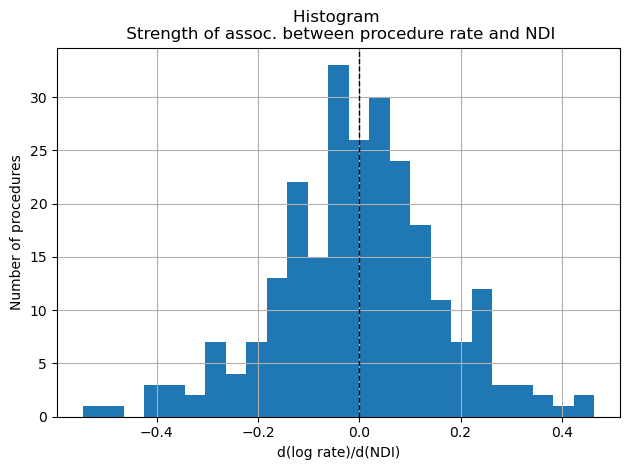

In [69]:
df_procs_250.slope_ses.hist(bins=25)

plt.axvline(0,linestyle='--', color='k', lw=1)

plt.title('Histogram \n Strength of assoc. between procedure rate and NDI')

plt.xlabel('d(log rate)/d(NDI)')
plt.ylabel('Number of procedures')
plt.tight_layout()
plt.savefig('temp.jpg', dpi=400)

In [70]:
df_procs_250.slope_ses.describe()

count    250.000000
mean      -0.002064
std        0.164278
min       -0.545866
25%       -0.106644
50%        0.003837
75%        0.093104
max        0.464012
Name: slope_ses, dtype: float64

In [71]:
np.percentile(df_procs_250.slope_ses, 5)

-0.2818462318724167

In [72]:
np.percentile(df_procs_250.slope_ses, 95)

0.25674366332885223

In [73]:
df_procs_250[df_procs_250.quartile == 'Q1'].sort_values(by='rate_SID', ascending=True)[-5:]

,procedure,rate_MS,err_rate_MS,rate_SID,err_rate_SID,rel_bias,rel_bias_low,rel_bias_high,corr_ses,intercept_ses,slope_ses,slope_ses_se,alpha,quartile
29,Hip arthroplasty,0.109264,0.000945,0.085960,0.000045,1.271115,1.249710,1.292886,-0.095769,-8.671541,-0.314472,0.005294,8.445776,Q1
23,Substance use detoxification,0.058053,0.000689,0.104827,0.000050,0.553797,0.541056,0.566837,-0.061623,-8.425211,-0.219775,0.004834,21.901399,Q1
7,Perineal skin repair (1st degree obstetrical a...,0.187088,0.001237,0.259890,0.000079,0.719872,0.710597,0.729268,-0.060331,-7.522364,-0.147504,0.003151,17.719814,Q1
5,Perineal muscle laceration repair (2nd degree ...,0.306903,0.001584,0.355728,0.000092,0.862748,0.854055,0.871529,-0.158862,-7.276095,-0.349811,0.002602,10.871678,Q1
2,Assisted vaginal delivery,0.396079,0.001799,0.478644,0.000107,0.827502,0.820158,0.834911,-0.056239,-6.908276,-0.135447,0.002326,14.649358,Q1


In [74]:
df_procs_250[df_procs_250.quartile == 'Q3'].sort_values(by='rate_SID', ascending=False)[0:5]

,procedure,rate_MS,err_rate_MS,rate_SID,err_rate_SID,rel_bias,rel_bias_low,rel_bias_high,corr_ses,intercept_ses,slope_ses,slope_ses_se,alpha,quartile
19,Regional anesthesia,0.092763,0.000871,0.122807,0.000054,0.755359,0.741574,0.769400,-0.002921,-8.237656,-0.012124,0.004687,26.776917,Q3
21,"Administration of therapeutic substances, NEC",0.067215,0.000741,0.107896,0.000051,0.622958,0.609626,0.636581,-0.005797,-8.370170,-0.017861,0.005001,26.056884,Q3
26,"Pregnancy and fetal procedures, NEC",0.048098,0.000627,0.095350,0.000048,0.504434,0.491700,0.517498,-0.009579,-8.507974,-0.027025,0.005344,23.386294,Q3
32,Percutaneous coronary interventions (PCI),0.076287,0.000790,0.083394,0.000045,0.914768,0.896373,0.933541,-0.001498,-8.619607,-0.004317,0.005684,11.263021,Q3
34,Gastrectomy,0.086282,0.000840,0.080848,0.000044,1.067211,1.047015,1.087797,0.005296,-8.654972,0.015732,0.005819,17.885115,Q3


In [75]:
df_procs_250[df_procs_250.quartile == 'Q5'].sort_values(by='rate_SID', ascending=False)[0:5]

,procedure,rate_MS,err_rate_MS,rate_SID,err_rate_SID,rel_bias,rel_bias_low,rel_bias_high,corr_ses,intercept_ses,slope_ses,slope_ses_se,alpha,quartile
3,Venous and arterial catheter placement,0.194811,0.001262,0.430164,0.000101,0.452876,0.447159,0.458666,0.052128,-6.981554,0.136271,0.002593,10.922531,Q5
6,Transfusion of blood and blood products,0.111978,0.000957,0.341535,0.000090,0.327867,0.322420,0.333406,0.043128,-7.209104,0.120167,0.002897,13.888172,Q5
10,Mechanical ventilation,0.077537,0.000796,0.229830,0.000074,0.337366,0.330642,0.344227,0.064346,-7.605492,0.180910,0.003578,11.818352,Q5
11,Hemodialysis,0.046194,0.000614,0.229241,0.000074,0.201507,0.196320,0.206831,0.123241,-7.647656,0.416490,0.003810,21.645428,Q5
14,Airway intubation,0.057186,0.000684,0.175538,0.000065,0.325778,0.318230,0.333505,0.066604,-7.876597,0.189162,0.004106,13.391602,Q5


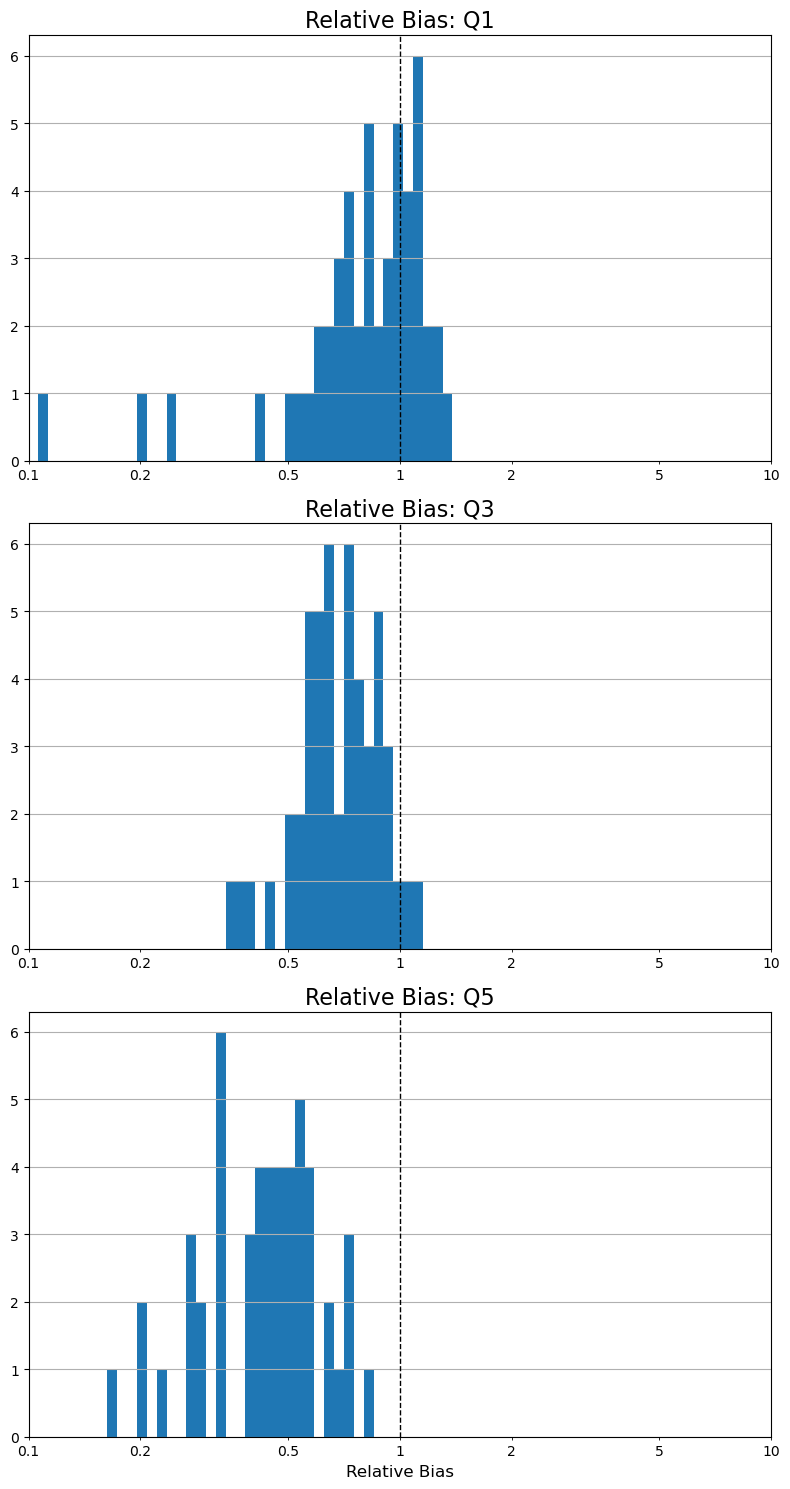

In [76]:
fig, axes = plt.subplots(3,1,figsize=(8,15))


plt.subplot(3,1,1)

#weights = np.ones(50) / 2.5
df_procs_250[df_procs_250.quartile=='Q1'].rel_bias.hist(
    #weights=weights,
    bins=np.logspace(np.log10(0.1),np.log10(2.0), 50),
    ax=axes[0])

axes[0].set_xscale('log')
axes[0].set_title('Relative Bias: Q1', fontsize=16)

#plt.gca().set_xscale("log")
plt.axvline(1,linestyle='--', color='k', lw=1)
plt.xlim([0.1, 10])

axes[0] = plt.gca()
locs = np.array([.1, 0.2, 0.5,  1, 2, 5, 10])
labels = np.array(['0.1', '0.2', '0.5', '1', '2', '5','10'])

axes[0].xaxis.set_minor_locator(ticker.FixedLocator(locs))
axes[0].xaxis.set_minor_formatter(ticker.FixedFormatter(labels))
axes[0].xaxis.set_major_locator(ticker.NullLocator())




plt.subplot(3,1,2)

#weights = np.ones(50) / 2.5
df_procs_250[df_procs_250.quartile=='Q3'].rel_bias.hist(
    #weights=weights,
    bins=np.logspace(np.log10(0.1),np.log10(2.0), 50),
    ax=axes[1])

axes[1].set_xscale('log')
axes[1].set_title('Relative Bias: Q3', fontsize=16)

plt.axvline(1,linestyle='--', color='k', lw=1)
plt.xlim([0.1, 10])

axes[1] = plt.gca()
locs = np.array([.1, 0.2, 0.5,  1, 2, 5, 10])
labels = np.array(['0.1', '0.2', '0.5', '1', '2', '5','10'])

axes[1].xaxis.set_minor_locator(ticker.FixedLocator(locs))
axes[1].xaxis.set_minor_formatter(ticker.FixedFormatter(labels))
axes[1].xaxis.set_major_locator(ticker.NullLocator())




plt.subplot(3,1,3)

#weights = np.ones(50) / 2.5
df_procs_250[df_procs_250.quartile=='Q5'].rel_bias.hist(
    #weights=weights,
    bins=np.logspace(np.log10(0.1),np.log10(2.0), 50),
    ax=axes[2])

axes[2].set_xscale('log')

plt.xlabel('Relative Bias', fontsize=12)
plt.ylabel('', fontsize=12)

plt.title('Relative Bias: Q5', fontsize=16)

#plt.gca().set_xscale("log")
plt.axvline(1,linestyle='--', color='k', lw=1)
plt.xlim([0.1, 10])

axes[2] = plt.gca()
locs = np.array([.1, 0.2, 0.5,  1, 2, 5, 10])
labels = np.array(['0.1', '0.2', '0.5', '1', '2', '5','10'])

axes[2].xaxis.set_minor_locator(ticker.FixedLocator(locs))
axes[2].xaxis.set_minor_formatter(ticker.FixedFormatter(labels))
axes[2].xaxis.set_major_locator(ticker.NullLocator())

plt.tight_layout()
plt.savefig('temp.jpg', dpi=400)

In [77]:
df_procs_250.sort_values(by='rel_bias', ascending=False)[-10:]

,procedure,rate_MS,err_rate_MS,rate_SID,err_rate_SID,rel_bias,rel_bias_low,rel_bias_high,corr_ses,intercept_ses,slope_ses,slope_ses_se,alpha,quartile
144,Isolation procedures,0.003580,0.000171,0.015125,0.000019,0.236678,0.215512,0.259923,-0.025418,-10.352148,-0.212381,0.012702,504.056656,Q1
94,Cardiac chest compression,0.006220,0.000225,0.027107,0.000025,0.229447,0.213705,0.246348,0.066185,-9.750790,0.238703,0.010594,22.600246,Q5
124,Cardiac monitoring,0.004495,0.000192,0.019792,0.000022,0.227121,0.208905,0.246925,-0.004384,-10.065532,-0.065157,0.011519,730.521205,Q2
56,Transfusion of plasma,0.011851,0.000311,0.053770,0.000036,0.220400,0.209339,0.232045,0.022849,-9.053565,0.080193,0.007220,17.961674,Q4
42,Psychotherapy for mental health (excluding sub...,0.013682,0.000334,0.067442,0.000040,0.202864,0.193372,0.212822,-0.025574,-8.858801,-0.135441,0.006169,89.821303,Q1
11,Hemodialysis,0.046194,0.000614,0.229241,0.000074,0.201507,0.196320,0.206831,0.123241,-7.647656,0.416490,0.003810,21.645428,Q5
182,Cardiac stress tests,0.001863,0.000123,0.009405,0.000015,0.198133,0.174007,0.225604,0.044025,-10.812339,0.253305,0.018062,154.704232,Q5
185,Subcutaneous contraceptive implant,0.001553,0.000113,0.009041,0.000015,0.171753,0.148983,0.198004,0.046665,-10.857015,0.274169,0.018542,183.470538,Q5
170,"Mental health procedures, NEC",0.001357,0.000105,0.010967,0.000016,0.123709,0.106249,0.144040,-0.012358,-10.687894,-0.118883,0.015475,697.238850,Q2
60,Pharmacotherapy for mental health (excluding s...,0.004994,0.000202,0.045622,0.000033,0.109457,0.101112,0.118491,-0.019973,-9.253890,-0.152016,0.007478,231.195120,Q1


In [78]:
df_procs_250.sort_values(by = 'slope_ses') #[(df_procs_250.rel_bias > .95) & (df_procs_250.rel_bias < 1.05)]

,procedure,rate_MS,err_rate_MS,rate_SID,err_rate_SID,rel_bias,rel_bias_low,rel_bias_high,corr_ses,intercept_ses,slope_ses,slope_ses_se,alpha,quartile
142,Breast reconstruction,0.017744,0.000381,0.015177,0.000019,1.169082,1.120844,1.219397,-0.143889,-10.514212,-0.545866,0.012184,8.811793,Q1
247,Psychotherapy for substance use,0.001520,0.000111,0.003602,0.000009,0.422064,0.365532,0.487339,-0.042761,-11.928727,-0.494247,0.025227,1764.248562,Q1
135,Counseling for substance use,0.012276,0.000317,0.017153,0.000020,0.715668,0.680339,0.752832,-0.080379,-10.271732,-0.422745,0.011315,53.441343,Q1
84,Anorectal repair (3rd and 4th degree obstetric...,0.029578,0.000492,0.030500,0.000027,0.969782,0.938651,1.001944,-0.161192,-9.763481,-0.421575,0.008788,14.322054,Q1
145,Mastectomy and lumpectomy,0.014025,0.000339,0.014821,0.000019,0.946300,0.902510,0.992214,-0.093186,-10.473185,-0.406829,0.012601,13.066888,Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,Below knee amputation,0.004332,0.000188,0.010463,0.000016,0.414002,0.380195,0.450816,0.045158,-10.728122,0.368317,0.017658,23.306721,Q5
212,Peripheral arteriovenous fistula and shunt pro...,0.001716,0.000118,0.006172,0.000012,0.278095,0.242901,0.318388,0.079406,-11.256723,0.375957,0.023025,55.939269,Q5
11,Hemodialysis,0.046194,0.000614,0.229241,0.000074,0.201507,0.196320,0.206831,0.123241,-7.647656,0.416490,0.003810,21.645428,Q5
244,Above knee and other proximal lower extremity ...,0.001496,0.000111,0.003830,0.000010,0.390511,0.337811,0.451433,0.069255,-11.729031,0.428892,0.029371,41.228584,Q5


In [117]:
#df_temp = df_procs_250.sort_values(by='rate_SID')[-100:].copy() 

#df_temp = df_procs_250[(~df_procs_250.procedure.str.contains('sycho')) 
#             & (~df_procs_250.procedure.str.contains('ental health')) ].copy()

df_temp=df_procs_250.copy()
df_temp['log_rel_bias'] = np.log(df_temp.rel_bias)

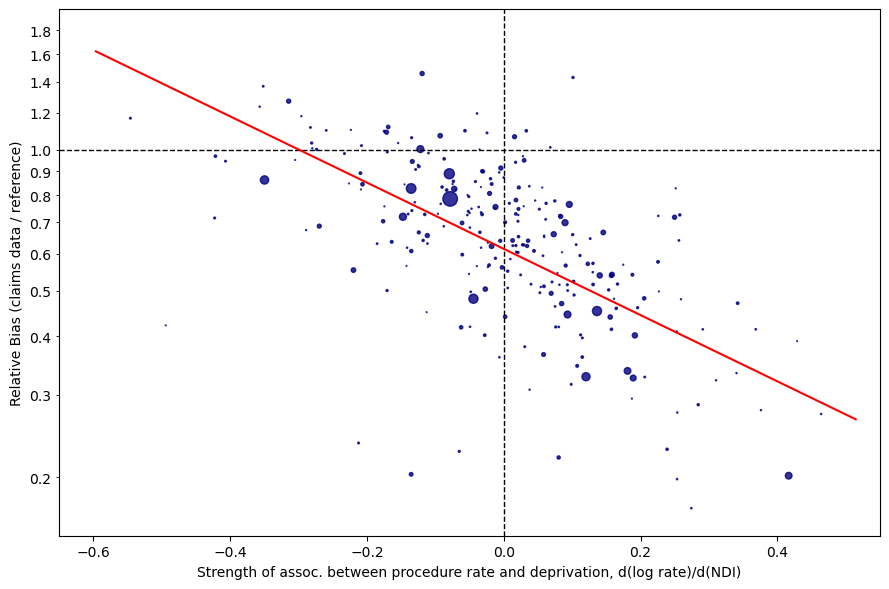

In [118]:
fig, ax = plt.subplots(1,1,figsize=(9,6))

sns.regplot(y='rel_bias', x = 'slope_ses', data=df_temp,
            scatter_kws={'s': df_temp['rate_SID']*100,  'color':'navy'}, fit_reg = False)

#ax.errorbar(x=df_temp['slope_ses'], y=df_temp['log_rel_bias'], 
#            xerr=1.96*df_temp['slope_ses_se'], 
#            yerr=df_temp['log_rel_bias'] - np.log(df_temp['rel_bias_low']), 
#            fmt='none', capsize=2, color='k')

#sns.regplot(y='log_rel_bias', x = 'slope_ses', data=df_temp,
#            scatter_kws={'s': 3,  'color':'red', 'zorder':4}, fit_reg = False)

plt.axhline(1,linestyle='--', color='k', lw=1,)
plt.axvline(0,linestyle='--', color='k', lw=1,)

ax.set_yscale('log')

est = sm.WLS(exog = sm.add_constant(df_temp['slope_ses']),
             endog = df_temp.log_rel_bias,
             #weights=df_temp['rate_SID']
             weights=df_temp['slope_ses_se']**-2).fit()
intercept = est.params['const']
slope = est.params['slope_ses']
x_vals = np.array(plt.xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, np.exp(y_vals), 'r-')

plt.xlim([-0.65, 0.55])
#plt.xlim([-0.21, 0.21])
plt.ylim([0.15, 2.0])

locs = np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 1.2, 1.4, 1.6, 1.8])
labels = np.array(['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0', '1.2', '1.4', '1.6', '1.8'])

ax.yaxis.set_minor_locator(ticker.FixedLocator(locs))
ax.yaxis.set_minor_formatter(ticker.FixedFormatter(labels))
ax.yaxis.set_major_locator(ticker.NullLocator())

#plt.title('Procedures with more bias occur disproportionately in lower SES zip codes', size=14)

plt.xlabel('Strength of assoc. between procedure rate and deprivation, d(log rate)/d(NDI)')

plt.ylabel('Relative Bias (claims data / reference)')
plt.tight_layout()
plt.savefig('temp.jpg', dpi=400)

In [94]:
df_temp['abs_resid'] = np.abs(est.resid)
df_temp.sort_values(by='abs_resid', ascending = False)[0:20]

,procedure,rate_MS,err_rate_MS,rate_SID,err_rate_SID,rel_bias,rel_bias_low,rel_bias_high,corr_ses,intercept_ses,slope_ses,slope_ses_se,alpha,quartile,log_rel_bias,abs_resid
60,Pharmacotherapy for mental health (excluding s...,0.004994,0.000202,0.045622,0.000033,0.109457,0.101112,0.118491,-0.019973,-9.253890,-0.152016,0.007478,231.195120,Q1,-2.212222,1.973301
170,"Mental health procedures, NEC",0.001357,0.000105,0.010967,0.000016,0.123709,0.106249,0.144040,-0.012358,-10.687894,-0.118883,0.015475,697.238850,Q2,-2.089820,1.796930
42,Psychotherapy for mental health (excluding sub...,0.013682,0.000334,0.067442,0.000040,0.202864,0.193372,0.212822,-0.025574,-8.858801,-0.135441,0.006169,89.821303,Q1,-1.595220,1.329300
144,Isolation procedures,0.003580,0.000171,0.015125,0.000019,0.236678,0.215512,0.259923,-0.025418,-10.352148,-0.212381,0.012702,504.056656,Q1,-1.441053,1.300461
247,Psychotherapy for substance use,0.001520,0.000111,0.003602,0.000009,0.422064,0.365532,0.487339,-0.042761,-11.928727,-0.494247,0.025227,1764.248562,Q1,-0.862598,1.181133
124,Cardiac monitoring,0.004495,0.000192,0.019792,0.000022,0.227121,0.208905,0.246925,-0.004384,-10.065532,-0.065157,0.011519,730.521205,Q2,-1.482274,1.101871
106,Gastro-jejunal bypass (including bariatric),0.033370,0.000522,0.023363,0.000024,1.428356,1.385120,1.472942,0.030075,-9.885108,0.101221,0.010998,23.939794,Q4,0.356524,1.007940
56,Transfusion of plasma,0.011851,0.000311,0.053770,0.000036,0.220400,0.209339,0.232045,0.022849,-9.053565,0.080193,0.007220,17.961674,Q4,-1.512312,0.895149
185,Subcutaneous contraceptive implant,0.001553,0.000113,0.009041,0.000015,0.171753,0.148983,0.198004,0.046665,-10.857015,0.274169,0.018542,183.470538,Q5,-1.761695,0.828568
182,Cardiac stress tests,0.001863,0.000123,0.009405,0.000015,0.198133,0.174007,0.225604,0.044025,-10.812339,0.253305,0.018062,154.704232,Q5,-1.618817,0.719674


In [95]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:           log_rel_bias   R-squared:                       0.365
Model:                            WLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     142.7
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           2.74e-26
Time:                        12:37:28   Log-Likelihood:                -174.95
No. Observations:                 250   AIC:                             353.9
Df Residuals:                     248   BIC:                             360.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4865      0.021    -23.393      0.000      -0.528      -0.446
slope_ses     -1.6289      0.136    -11.947      0.000      -1.897      -1.360
==============================================================================
Omnibus:                      113.932   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              787.204
Skew:                          -1.664   Prob(JB):                    1.15e-171
Kurtosis:                      11.031   Cond. No.                         6.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

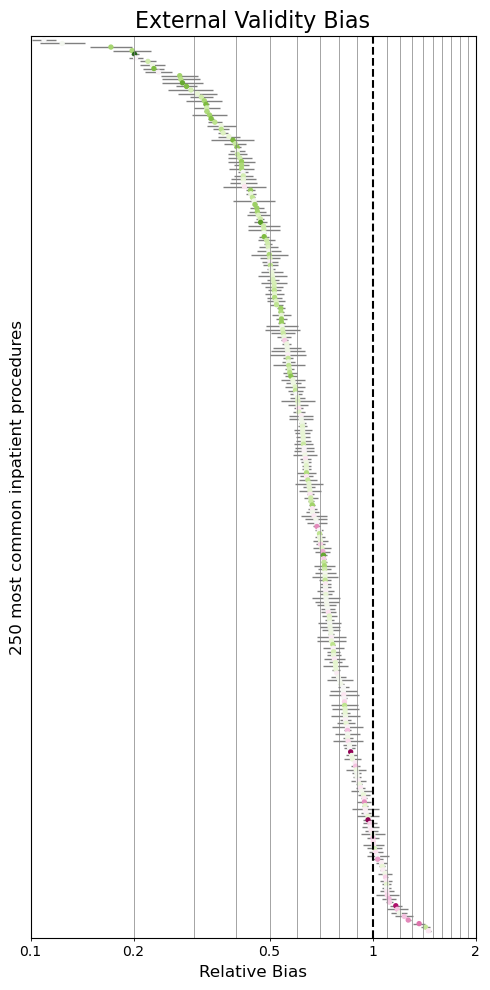

In [96]:
plt.figure(figsize=(5,10))

df_temp = df_procs_250.sort_values(by='rel_bias').copy()

err = np.array([np.array(df_temp['rel_bias']        - df_temp['rel_bias_low'])  ,
                np.array(df_temp['rel_bias_high']   - df_temp['rel_bias'])   ])

plt.scatter(df_temp['rel_bias'],df_temp['procedure'],  s=8, zorder=2,
            c = df_temp['corr_ses'] / .15,
           cmap = 'PiYG')
            # color='k')
plt.barh(df_temp['procedure'], df_temp['rel_bias'], xerr=err, facecolor='none', 
         error_kw=dict(lw=1, capsize=0, capthick=0, ecolor='gray'), zorder=1)


plt.xscale('log')
plt.gca().invert_yaxis()

plt.xlabel('Relative Bias', fontsize=12)
plt.ylabel('250 most common inpatient procedures', fontsize=12)

plt.title('External Validity Bias', fontsize=16)


plt.axvline(1,linestyle='--', color='k', lw=1.5)
#plt.axvline(df_procs[df_procs.procedure == 'Overall Inpatient Visits'].rel_bias.values[0],linestyle=':', color='gray', lw=1)
plt.axvline(.2, color='gray', linewidth=0.5)
plt.axvline(.3, color='gray', linewidth=0.5)
plt.axvline(.4, color='gray', linewidth=0.5)
plt.axvline(.5, color='gray', linewidth=0.5)
plt.axvline(.6, color='gray', linewidth=0.5)
plt.axvline(.7, color='gray', linewidth=0.5)
plt.axvline(.8, color='gray', linewidth=0.5)
plt.axvline(.9, color='gray', linewidth=0.5)
plt.axvline(1.1, color='gray', linewidth=0.5)
plt.axvline(1.2, color='gray', linewidth=0.5)
plt.axvline(1.3, color='gray', linewidth=0.5)
plt.axvline(1.4, color='gray', linewidth=0.5)
plt.axvline(1.5, color='gray', linewidth=0.5)
plt.axvline(1.6, color='gray', linewidth=0.5)
plt.axvline(1.7, color='gray', linewidth=0.5)
plt.axvline(1.8, color='gray', linewidth=0.5)
plt.axvline(1.9, color='gray', linewidth=0.5)
plt.axvline(2.0, color='gray', linewidth=0.5)
plt.axvline(2.1, color='gray', linewidth=0.5)
plt.axvline(2.2, color='gray', linewidth=0.5)
plt.axvline(2.3, color='gray', linewidth=0.5)
plt.axvline(2.4, color='gray', linewidth=0.5)
plt.xlim([0.1, 2])

plt.ylim([251, -1])

ax = plt.gca()
locs = np.array([.1, 0.2, 0.5,  1, 2, 5, 10])
labels = np.array(['0.1', '0.2', '0.5', '1', '2', '5','10'])

ax.xaxis.set_minor_locator(ticker.FixedLocator(locs))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(labels))
ax.xaxis.set_major_locator(ticker.NullLocator())

ax.yaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_minor_locator(ticker.NullLocator())

plt.tight_layout()
plt.savefig('temp.jpg', dpi = 400)

In [70]:
df_procs_250.to_csv('procs_250.csv')

In [105]:
proc

'Hip arthroplasty'

In [112]:
df_temp[df_temp.procedure=='Hip arthroplasty'].reset_index().PRCCSR[0]

0      MST007
1      MST007
2      MST007
3      MST007
4      MST007
        ...  
205    MST007
206    MST007
207    MST007
208    MST007
209    MST007
Name: PRCCSR, Length: 210, dtype: object

In [114]:
df_temp = pd.merge(df_procs_250, df_pccrs, left_on='procedure', right_on = 'PRCCSR DESCRIPTION')
df_codes = pd.DataFrame([], columns = ['procedure', 'PRCCSR code', 'ICD-10-PCS codes'])
ii = 0
for proc in set(df_temp.procedure):
    PRCCSR_code = df_temp[df_temp.procedure==proc].reset_index().PRCCSR[0]
    ICD_PCS_codes = ', '.join(df_temp[df_temp.procedure==proc]['ICD-10-PCS'])
    df_codes.loc[ii] = [proc, PRCCSR_code, ICD_PCS_codes]
    ii += 1
df_codes

,procedure,PRCCSR code,ICD-10-PCS codes
0,Hip arthroplasty,MST007,"0SH908Z, 0SH938Z, 0SH948Z, 0SHB08Z, 0SHB38Z, 0..."
1,Other GI system device procedures,GIS025,"0D20XUZ, 0D20XYZ, 0D2DXUZ, 0D2DXYZ, 0D2UXYZ, 0..."
2,Cardiac and coronary fluoroscopy,IMG001,"B210010, B2100ZZ, B210110, B2101ZZ, B210Y10, B..."
3,Transfusion of plasma,ADM002,"30230K0, 30230K1, 30230L0, 30230L1, 30230M0, 3..."
4,Airway intubation,RES007,"0BH17EZ, 0BH18EZ, 0DH57BZ, 0DH58BZ"
...,...,...,...
245,Nasal and sinus excision,ENT008,"095B0ZZ, 095B3ZZ, 095B4ZZ, 095B8ZZ, 095C0ZZ, 0..."
246,"Lung, pleura, or diaphragm biopsy (non-endosco...",RES002,"0B910ZX, 0B913ZX, 0B914ZX, 0B917ZX, 0B920ZX, 0..."
247,Lymph node biopsy,LYM001,"07900ZX, 07903ZX, 07904ZX, 07908ZX, 07910ZX, 0..."
248,"Administration of therapeutic substances, NEC",ADM021,"3E00XGC, 3E00XMZ, 3E00XTZ, 3E013GC, 3E013TZ, 3..."


In [115]:
df_codes.to_csv('codes.csv')

# Study MarketScan Coverage in 2019

In [3]:
df_census = pd.read_csv('msa_census_2018.csv')

In [4]:
xls = pd.ExcelFile('marketscan_counts.xlsx')

# Now you can list all sheets in the file
xls.sheet_names

['mem_days', 'hip_replacements', 'mem_days_medi', 'hip_replacements_medi']

In [5]:
df1 = pd.read_excel(xls, 'mem_days')
df2 = pd.read_excel(xls, 'hip_replacements')
df3 = pd.read_excel(xls, 'mem_days_medi')
df4 = pd.read_excel(xls, 'hip_replacements_medi')

In [6]:
df_comm = pd.merge(df1, df2, how='outer', on=['EGEOLOC', 'MSA']).rename(columns={'mem_days':'mem_days_comm', 'count':'hip_replacements_comm'})
df_medi = pd.merge(df3, df4, how='outer', on=['EGEOLOC', 'MSA']).rename(columns={'mem_days':'mem_days_medi', 'hip_replacements':'hip_replacements_medi'})

df_ms = pd.merge(df_comm, df_medi, how='outer', on=['EGEOLOC', 'MSA'])

df_ms['hip_rate_comm'] = (df_ms.hip_replacements_comm / df_ms.mem_days_comm).fillna(0) * 36500
df_ms['hip_rate_medi'] = (df_ms.hip_replacements_medi / df_ms.mem_days_medi).fillna(0) * 36500
df_ms['hip_rate_ms'] = ((df_ms.hip_replacements_comm + df_ms.hip_replacements_medi) / (df_ms.mem_days_comm + df_ms.mem_days_medi)).fillna(0) * 36500

In [7]:
df_ms[df_ms.EGEOLOC==1]

,MSA,EGEOLOC,mem_days_comm,hip_replacements_comm,mem_days_medi,hip_replacements_medi,hip_rate_comm,hip_rate_medi,hip_rate_ms
2,34820.0,1,6964784.0,NaN,2555.0,NaN,0.0,0.0,0.0
3,0.0,1,156667386.0,NaN,19364446.0,NaN,0.0,0.0,0.0
4,22900.0,1,733379.0,NaN,730.0,NaN,0.0,0.0,0.0
5,23580.0,1,495736.0,NaN,730.0,NaN,0.0,0.0,0.0
6,12260.0,1,18198797.0,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
706,48300.0,1,NaN,NaN,881.0,NaN,0.0,0.0,0.0
707,48900.0,1,NaN,NaN,6175.0,NaN,0.0,0.0,0.0
708,49180.0,1,NaN,NaN,6813.0,NaN,0.0,0.0,0.0
709,49340.0,1,NaN,NaN,5536.0,NaN,0.0,0.0,0.0


In [9]:
df_ms['mem_days_comm'].sum() / (df_census['Total Pop'] *  (1-df_census.frac_over_65)).sum() / 365 * 100

6.7124427135613995

In [10]:
df_ms[(df_ms.MSA.isna()) | (df_ms.EGEOLOC == 1)].mem_days_comm.sum() / df_ms.mem_days_comm.sum() * 100

13.574582973932491

In [11]:
df_ms['mem_days_medi'].sum() / (df_census['Total Pop'] *  (df_census.frac_over_65)).sum() / 365 * 100

1.1770184031591049

In [12]:
df_ms[(df_ms.MSA.isna()) | (df_ms.EGEOLOC == 1)].mem_days_medi.sum() / df_ms.mem_days_medi.sum() * 100

62.89505865631183

In [14]:
df = pd.merge(df_census, df_ms, on=['MSA', 'EGEOLOC'])

In [15]:
df['coverage_comm'] = df['mem_days_comm'] / df['Total Pop'] / (1-df.frac_over_65) / 365
df['coverage_medi'] = df['mem_days_medi'] / df['Total Pop'] / (df.frac_over_65) / 365

In [16]:
df.coverage_comm.fillna(0, inplace=True)
df.coverage_medi.fillna(0, inplace=True)

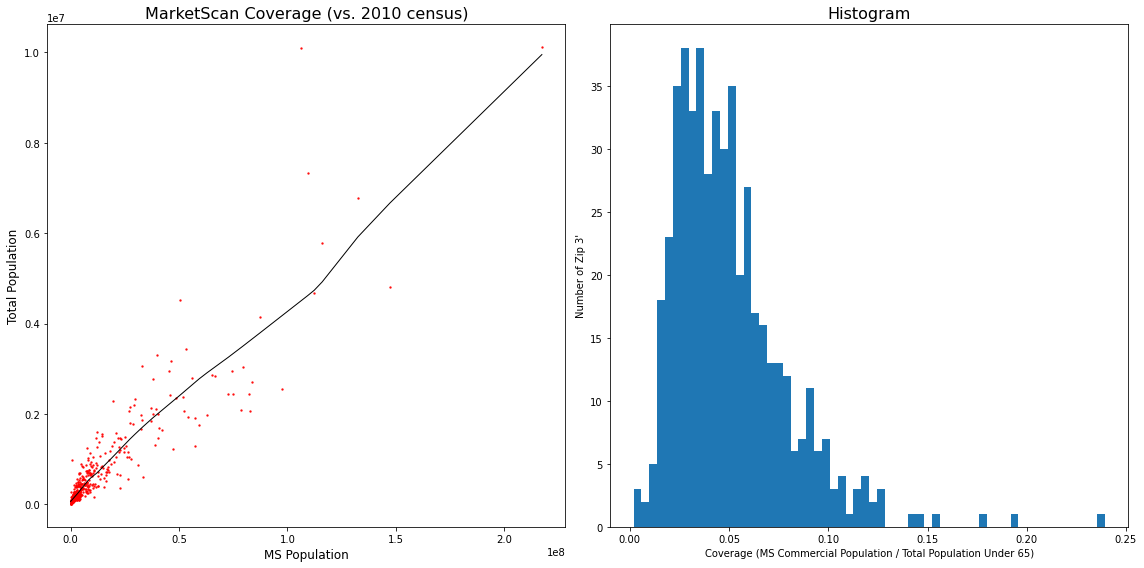

In [21]:
df_plot = df.copy()

plt.subplots(1,2,figsize=(16,8))

plt.subplot(1,2,1)
#plt.plot(df_plot['count']/1000, df_plot['Total Pop']/1000, '.', alpha = 0.25)
#plt.xlim([0,16000])
#plt.ylim([0,160000])
sns.regplot(x = 'mem_days_comm', y = 'Total Pop', data = df_plot, lowess=True, scatter_kws={'color':'r', 's':2}, line_kws={'color':'black', 'linewidth':'1'})
plt.xlabel('MS Population', fontsize=12)
plt.ylabel('Total Population', fontsize=12)
plt.title('MarketScan Coverage (vs. 2010 census)', fontsize=16)

plt.subplot(1,2,2)

plt.hist(df_plot[df_plot.coverage_comm < 1].coverage_comm, bins=60)
plt.title('Histogram', fontsize=16)
plt.xlabel('Coverage (MS Commercial Population / Total Population Under 65)')
plt.ylabel('Number of Zip 3\'')

plt.tight_layout()
#plt.savefig('coverage_MS.jpg')


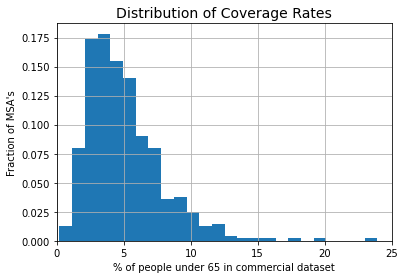

In [22]:
(100*df.coverage_comm).hist(bins=25, density=True)
plt.title('Distribution of Coverage Rates', fontsize=14)
plt.xlabel('% of people under 65 in commercial dataset')
plt.ylabel('Fraction of MSA\'s')
plt.xlim(0,25)

plt.savefig('temp.jpg', dpi=400)

In [23]:
df[['coverage_comm', 'Name', 'State Name']].sort_values(by='coverage_comm', ascending=False)

,coverage_comm,Name,State Name
225,0.239332,"Monroe, MI",Michigan
233,0.195240,"Ann Arbor, MI",Michigan
331,0.178601,"Toledo, OH",Ohio
79,0.154276,"Wilmington, DE-MD-NJ",Delaware
232,0.147975,"Midland, MI",Michigan
...,...,...,...
27,0.009652,"Pine Bluff, AR",Arkansas
53,0.009219,"El Centro, CA",California
125,0.002152,"Kahului-Wailuku-Lahaina, HI",Hawaii
124,0.001888,"Urban Honolulu, HI",Hawaii


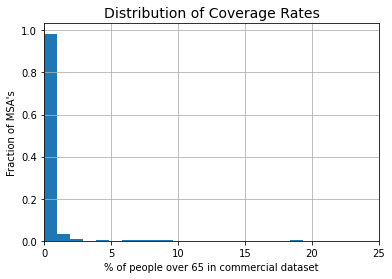

In [24]:
(100*df.coverage_medi).hist(bins=20,density=True)
plt.title('Distribution of Coverage Rates', fontsize=14)
plt.xlabel('% of people over 65 in commercial dataset')
plt.ylabel('Fraction of MSA\'s')
plt.xlim(0,25)

plt.savefig('temp.jpg', dpi=400)

In [26]:
df[['coverage_medi', 'Name', 'State Name']].sort_values(by='coverage_medi', ascending=False)

,coverage_medi,Name,State Name
233,0.193091,"Ann Arbor, MI",Michigan
225,0.095882,"Monroe, MI",Michigan
236,0.083179,"Battle Creek, MI",Michigan
230,0.075129,"Lansing-East Lansing, MI",Michigan
228,0.063518,"Grand Rapids-Wyoming, MI",Michigan
...,...,...,...
173,0.000000,"Davenport-Moline-Rock Island, IA-IL",Iowa
304,0.000000,"Utica-Rome, NY",New York
293,0.000000,"Albany-Schenectady-Troy, NY",New York
180,0.000000,"St. Joseph, MO-KS",Kansas


In [233]:
df[['coverage_comm', 'coverage_medi']].describe()

,coverage_comm,coverage_medi
count,502.000000,502.000000
mean,0.050266,0.003905
std,0.028563,0.011499
min,0.001878,0.000000
25%,0.029670,0.001183
50%,0.044706,0.001932
75%,0.063219,0.003504
max,0.239332,0.193091


In [241]:
np.percentile(df['coverage_medi'],5)

0.0003673705944335126

In [27]:
#what kind of MSA has more representation?

In [28]:
df['Total Pop 100k'] = df['Total Pop'] / 1000
df['Pop Density 1k'] = df['pop_density'] / 10
df['Log Pop Density'] = np.log10(df['pop_density']) / 100
df['Median House Price 100k'] = df['median_house_price'] / 1000

In [374]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

In [30]:
coverage_feature='coverage_comm'

df['phat'] = df[coverage_feature].clip(lower = np.percentile(df[coverage_feature], 10), upper = np.percentile(df[coverage_feature], 90))
df['weight'] = df['Total Pop']/df['phat']/(1-df['phat'])

In [31]:
features = ['Total Pop 100k', 'Log Pop Density',
          #  'Pop Density 1k',
    #'frac_female',  
            'frac_asian', 'frac_black', 'frac_hispanic', 'frac_white', 'frac_other',
                    'frac_under_18', 'frac_18_to_39', 'frac_40_to_64', 'frac_over_65',
     'frac_lt_20k', 'frac_20k_to_40k', 'frac_40k_to_75k', 'frac_75k_to_125k', 'frac_125k_to_200k', 'frac_gt_200k', 
     'frac_unemployed', 'frac_no_health_insurance',
     'frac_lt_hs', 'frac_hs', 'frac_some_college', 'frac_college', 'frac_graduate',
     'frac_houses_owner_occupied', 
    'Median House Price 100k']

df_partial_corrs = pd.DataFrame([], columns = ['coef', 'std err', 'p', 'partial corr'])
i=0

for feature in features:
    
    print(feature)


    X = sm.add_constant(pd.get_dummies(df['State Name']).iloc[:,:-1]).astype(int)
    y = df[coverage_feature]*100
    weight = df['weight']

    est = sm.WLS(y, X, weights=weight).fit() 
    resid_Optum = est.resid


    y = df[feature]

    est = sm.WLS(y, X, weights = weight).fit() 
    resid_feature = est.resid

    X = sm.add_constant(df[feature])
    y = resid_Optum

    est = sm.WLS(y, X, weights = weight).fit() 

    results_as_html = est.summary().tables[1].as_html()
    temp = pd.read_html(results_as_html, header=0, index_col=0)[0]

    df_partial_corrs.loc[i] = list(temp.loc[feature,['coef', 'std err', 'P>|t|']]) + list([corr(resid_feature, resid_Optum, weight)])
    i += 1


Total Pop 100k
Log Pop Density
frac_asian
frac_black
frac_hispanic
frac_white
frac_other
frac_under_18
frac_18_to_39
frac_40_to_64
frac_over_65
frac_lt_20k
frac_20k_to_40k
frac_40k_to_75k
frac_75k_to_125k
frac_125k_to_200k
frac_gt_200k
frac_unemployed
frac_no_health_insurance
frac_lt_hs
frac_hs
frac_some_college
frac_college
frac_graduate
frac_houses_owner_occupied
Median House Price 100k


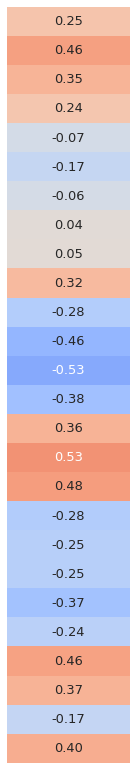

In [34]:
plt.figure(figsize=(2,10.8))


corr_mat =  df_partial_corrs[['partial corr']]

sns.heatmap(corr_mat,
           cmap = "coolwarm",  vmin=-1, vmax=1,  cbar=False, robust=True, annot = corr_mat, fmt = '.2f',
                annot_kws={'size':13})

plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('temp.jpg', dpi=400)


In [36]:
features = [ 'Total Pop 100k', 'Log Pop Density',
            #'Pop Density 1k',
            #'frac_female',
            'frac_asian',
            'frac_black',
            'frac_hispanic', 'frac_other', 
            'frac_18_to_39', 'frac_40_to_64', 'frac_over_65',
             'frac_20k_to_40k', 'frac_40k_to_75k', 'frac_75k_to_125k', 'frac_125k_to_200k', 'frac_gt_200k',
       'frac_unemployed', 'frac_no_health_insurance', 
        'frac_hs',  'frac_some_college', 'frac_college',
       'frac_graduate', 'frac_houses_owner_occupied', 'Median House Price 100k']


#features = []

X = sm.add_constant(df[features] ).fillna(0)

X = pd.concat([X, pd.get_dummies(df['State Name']).iloc[:,:-1].astype(int)], axis=1)
y = df[coverage_feature] 

est = sm.WLS(y, X, weights = df['weight']).fit() #maxiter=50000, method='nm') # weights = df_plot['Total Pop']
est.summary2()



<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Weighted least squares
==========================================================================
Model:                 WLS                Adj. R-squared:       0.589     
Dependent Variable:    coverage_comm      AIC:                  -2320.6164
Date:                  2023-04-16 09:39   BIC:                  -2012.6585
No. Observations:      502                Log-Likelihood:       1233.3    
Df Model:              72                 F-statistic:          10.97     
Df Residuals:          429                Prob (F-statistic):   9.46e-62  
R-squared:             0.648              Scale:                3733.9    
--------------------------------------------------------------------------
                            Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
const                       0.1868   0.1002  1.8645 0.0629 -0.0101  0.3836
Total Pop 100k             -0.0000   0.0000 -0.7808 0.4353 -0.0000  0.0000
Log Pop Density             0.7549   0.3104  2.4321 0.0154  0.1448  1.3649
frac_asian                 -0.1098   0.0400 -2.7457 0.0063 -0.1883 -0.0312
frac_black                  0.0022   0.0174  0.1253 0.9003 -0.0320  0.0364
frac_hispanic              -0.0164   0.0157 -1.0438 0.2971 -0.0472  0.0145
frac_other                 -0.0671   0.0426 -1.5750 0.1160 -0.1508  0.0166
frac_18_to_39              -0.2607   0.0897 -2.9069 0.0038 -0.4369 -0.0844
frac_40_to_64               0.0670   0.0972  0.6894 0.4910 -0.1240  0.2580
frac_over_65               -0.2076   0.0786 -2.6409 0.0086 -0.3620 -0.0531
frac_20k_to_40k            -0.1779   0.1616 -1.1009 0.2715 -0.4956  0.1397
frac_40k_to_75k            -0.0861   0.0941 -0.9146 0.3609 -0.2712  0.0989
frac_75k_to_125k            0.0416   0.1214  0.3432 0.7316 -0.1969  0.2802
frac_125k_to_200k           0.0405   0.1435  0.2824 0.7778 -0.2414  0.3225
frac_gt_200k                0.0974   0.1183  0.8234 0.4107 -0.1351  0.3299
frac_unemployed            -0.0340   0.1192 -0.2851 0.7757 -0.2682  0.2002
frac_no_health_insurance   -0.0499   0.0500 -0.9974 0.3191 -0.1481  0.0484
frac_hs                     0.1495   0.0772  1.9368 0.0534 -0.0022  0.3013
frac_some_college           0.0013   0.0538  0.0245 0.9805 -0.1044  0.1070
frac_college                0.0566   0.0756  0.7492 0.4541 -0.0920  0.2053
frac_graduate               0.0381   0.0868  0.4384 0.6613 -0.1326  0.2087
frac_houses_owner_occupied -0.1101   0.0331 -3.3205 0.0010 -0.1752 -0.0449
Median House Price 100k    -0.0000   0.0000 -0.4301 0.6673 -0.0001  0.0000
Alabama                     0.0240   0.0174  1.3825 0.1675 -0.0101  0.0581
Alaska                     -0.0116   0.0197 -0.5866 0.5578 -0.0503  0.0272
Arizona                     0.0299   0.0167  1.7951 0.0733 -0.0028  0.0627
Arkansas                   -0.0103   0.0171 -0.6017 0.5477 -0.0439  0.0233
California                 -0.0073   0.0163 -0.4468 0.6553 -0.0392  0.0247
Colorado                    0.0097   0.0161  0.6051 0.5454 -0.0218  0.0413
Connecticut                -0.0232   0.0183 -1.2673 0.2057 -0.0592  0.0128
Delaware                    0.0437   0.0230  1.8998 0.0581 -0.0015  0.0889
District of Columbia       -0.0408   0.0260 -1.5679 0.1177 -0.0920  0.0104
Florida                     0.0415   0.0167  2.4915 0.0131  0.0088  0.0742
Georgia                     0.0117   0.0165  0.7101 0.4780 -0.0207  0.0440
Hawaii                     -0.0181   0.0232 -0.7799 0.4359 -0.0637  0.0275
Idaho                       0.0054   0.0170  0.3187 0.7501 -0.0280  0.0389
Illinois                   -0.0049   0.0163 -0.2998 0.7645 -0.0369  0.0271
Indiana                     0.0030   0.0168  0.1799 0.8573 -0.0301  0.0361
Iowa                       -0.0079   0.0171 -0.4618 0.6445 -0.0414  0.0256
Kansas                      0.0314   0.0172  1.8255 0.0686 -0.0024  0.0652
Kentucky                    0.0245   0.0180  1.3589 0.1749 -0.0109  0.059

In [37]:
results_as_html = est.summary().tables[1].as_html()
temp = pd.read_html(results_as_html, header=0, index_col=0)[0]
temp[1:23]

,coef,std err,t,P>|t|,[0.025,0.975]
Total Pop 100k,-4.189000e-07,5.370000e-07,-0.781,0.435,-0.000001,6.360000e-07
Log Pop Density,7.549000e-01,3.100000e-01,2.432,0.015,0.145000,1.365000e+00
frac_asian,-1.098000e-01,4.000000e-02,-2.746,0.006,-0.188000,-3.100000e-02
frac_black,2.200000e-03,1.700000e-02,0.125,0.900,-0.032000,3.600000e-02
frac_hispanic,-1.640000e-02,1.600000e-02,-1.044,0.297,-0.047000,1.400000e-02
frac_other,-6.710000e-02,4.300000e-02,-1.575,0.116,-0.151000,1.700000e-02
frac_18_to_39,-2.607000e-01,9.000000e-02,-2.907,0.004,-0.437000,-8.400000e-02
frac_40_to_64,6.700000e-02,9.700000e-02,0.689,0.491,-0.124000,2.580000e-01
frac_over_65,-2.076000e-01,7.900000e-02,-2.641,0.009,-0.362000,-5.300000e-02
frac_20k_to_40k,-1.779000e-01,1.620000e-01,-1.101,0.272,-0.496000,1.400000e-01


In [49]:
coverage_feature='coverage_medi'

df['phat'] = df[coverage_feature].clip(lower = np.percentile(df[coverage_feature], 10), upper = np.percentile(df[coverage_feature], 50))
df['weight'] = df['Total Pop']/df['phat']/(1-df['phat'])

clip_height = 0.005

In [50]:
features = ['Total Pop 100k', 'Log Pop Density',
          #  'Pop Density 1k',
    #'frac_female',  
            'frac_asian', 'frac_black', 'frac_hispanic', 'frac_white', 'frac_other',
                    'frac_under_18', 'frac_18_to_39', 'frac_40_to_64', 'frac_over_65',
     'frac_lt_20k', 'frac_20k_to_40k', 'frac_40k_to_75k', 'frac_75k_to_125k', 'frac_125k_to_200k', 'frac_gt_200k', 
     'frac_unemployed', 'frac_no_health_insurance',
     'frac_lt_hs', 'frac_hs', 'frac_some_college', 'frac_college', 'frac_graduate',
     'frac_houses_owner_occupied', 
    'Median House Price 100k']

df_partial_corrs = pd.DataFrame([], columns = ['coef', 'std err', 'p', 'partial corr'])
i=0

for feature in features:
    
    print(feature)


    X = sm.add_constant(pd.get_dummies(df['State Name']).iloc[:,:-1]).astype(int)
    y = df[coverage_feature].clip(upper=clip_height)*100
    weight = df['weight']

    est = sm.WLS(y, X, weights=weight).fit() 
    resid_Optum = est.resid


    y = df[feature]

    est = sm.WLS(y, X, weights = weight).fit() 
    resid_feature = est.resid

    X = sm.add_constant(df[feature])
    y = resid_Optum

    est = sm.WLS(y, X, weights = weight).fit() 

    results_as_html = est.summary().tables[1].as_html()
    temp = pd.read_html(results_as_html, header=0, index_col=0)[0]

    df_partial_corrs.loc[i] = list(temp.loc[feature,['coef', 'std err', 'P>|t|']]) + list([corr(resid_feature, resid_Optum, weight)])
    i += 1


Total Pop 100k
Log Pop Density
frac_asian
frac_black
frac_hispanic
frac_white
frac_other
frac_under_18
frac_18_to_39
frac_40_to_64
frac_over_65
frac_lt_20k
frac_20k_to_40k
frac_40k_to_75k
frac_75k_to_125k
frac_125k_to_200k
frac_gt_200k
frac_unemployed
frac_no_health_insurance
frac_lt_hs
frac_hs
frac_some_college
frac_college
frac_graduate
frac_houses_owner_occupied
Median House Price 100k


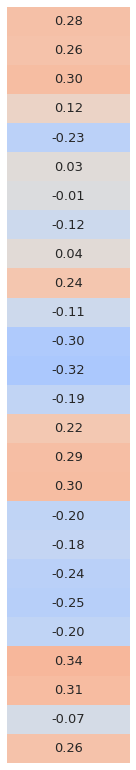

In [51]:
plt.figure(figsize=(2,10.8))


corr_mat =  df_partial_corrs[['partial corr']]

sns.heatmap(corr_mat,
           cmap = "coolwarm",  vmin=-1, vmax=1,  cbar=False, robust=True, annot = corr_mat, fmt = '.2f',
                annot_kws={'size':13})

plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('temp.jpg', dpi=400)


In [53]:
features = [ 'Total Pop 100k', 'Log Pop Density',
            #'Pop Density 1k',
            #'frac_female', 
             'frac_asian',
            'frac_black',
       'frac_hispanic', 'frac_other', 
            'frac_18_to_39', 'frac_40_to_64', 'frac_over_65',
             'frac_20k_to_40k', 'frac_40k_to_75k', 'frac_75k_to_125k', 'frac_125k_to_200k', 'frac_gt_200k',
       'frac_unemployed', 'frac_no_health_insurance', 
        'frac_hs',  'frac_some_college', 'frac_college',
       'frac_graduate', 'frac_houses_owner_occupied', 'Median House Price 100k']


#features = []

X = sm.add_constant(df[features] ).fillna(0)

X = pd.concat([X, pd.get_dummies(df['State Name']).iloc[:,:-1].astype(int)], axis=1)
y = df[coverage_feature].clip(upper=clip_height)

est = sm.WLS(y, X, weights = df['weight']).fit() #maxiter=50000, method='nm') # weights = df_plot['Total Pop']
est.summary2()



<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Weighted least squares
==========================================================================
Model:                 WLS                Adj. R-squared:       0.589     
Dependent Variable:    coverage_medi      AIC:                  -5046.7507
Date:                  2023-04-16 09:55   BIC:                  -4738.7929
No. Observations:      502                Log-Likelihood:       2596.4    
Df Model:              72                 F-statistic:          10.96     
Df Residuals:          429                Prob (F-statistic):   1.05e-61  
R-squared:             0.648              Scale:                466.06    
--------------------------------------------------------------------------
                            Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
const                      -0.0064   0.0066 -0.9651 0.3351 -0.0194  0.0066
Total Pop 100k              0.0000   0.0000  4.2895 0.0000  0.0000  0.0000
Log Pop Density             0.0090   0.0210  0.4267 0.6698 -0.0323  0.0502
frac_asian                  0.0012   0.0029  0.4086 0.6831 -0.0045  0.0069
frac_black                 -0.0008   0.0011 -0.7158 0.4745 -0.0030  0.0014
frac_hispanic              -0.0053   0.0010 -5.3648 0.0000 -0.0072 -0.0033
frac_other                 -0.0065   0.0030 -2.1498 0.0321 -0.0124 -0.0006
frac_18_to_39              -0.0017   0.0058 -0.2934 0.7693 -0.0130  0.0096
frac_40_to_64               0.0100   0.0064  1.5716 0.1168 -0.0025  0.0225
frac_over_65               -0.0097   0.0052 -1.8735 0.0617 -0.0200  0.0005
frac_20k_to_40k            -0.0095   0.0109 -0.8784 0.3802 -0.0309  0.0118
frac_40k_to_75k             0.0136   0.0065  2.0949 0.0368  0.0008  0.0263
frac_75k_to_125k            0.0082   0.0081  1.0080 0.3140 -0.0078  0.0241
frac_125k_to_200k          -0.0140   0.0093 -1.4981 0.1348 -0.0323  0.0044
frac_gt_200k                0.0040   0.0077  0.5214 0.6024 -0.0111  0.0192
frac_unemployed             0.0192   0.0080  2.4010 0.0168  0.0035  0.0350
frac_no_health_insurance    0.0090   0.0034  2.6027 0.0096  0.0022  0.0157
frac_hs                    -0.0002   0.0052 -0.0375 0.9701 -0.0105  0.0101
frac_some_college          -0.0031   0.0037 -0.8499 0.3958 -0.0104  0.0041
frac_college                0.0013   0.0051  0.2437 0.8076 -0.0089  0.0114
frac_graduate               0.0106   0.0058  1.8402 0.0664 -0.0007  0.0220
frac_houses_owner_occupied  0.0031   0.0022  1.4299 0.1535 -0.0012  0.0074
Median House Price 100k     0.0000   0.0000  0.2617 0.7937 -0.0000  0.0000
Alabama                     0.0005   0.0012  0.3898 0.6969 -0.0019  0.0028
Alaska                     -0.0002   0.0014 -0.1664 0.8679 -0.0029  0.0025
Arizona                     0.0035   0.0012  3.0508 0.0024  0.0013  0.0058
Arkansas                    0.0004   0.0012  0.2996 0.7646 -0.0020  0.0027
California                  0.0022   0.0011  1.9256 0.0548 -0.0000  0.0045
Colorado                    0.0029   0.0011  2.5495 0.0111  0.0007  0.0051
Connecticut                 0.0013   0.0013  0.9964 0.3196 -0.0012  0.0038
Delaware                    0.0034   0.0015  2.2457 0.0252  0.0004  0.0065
District of Columbia       -0.0006   0.0018 -0.3179 0.7507 -0.0040  0.0029
Florida                     0.0025   0.0012  2.1619 0.0312  0.0002  0.0048
Georgia                     0.0004   0.0011  0.3399 0.7341 -0.0019  0.0026
Hawaii                      0.0027   0.0017  1.5666 0.1179 -0.0007  0.0061
Idaho                       0.0002   0.0012  0.1792 0.8578 -0.0022  0.0026
Illinois                    0.0016   0.0011  1.4091 0.1595 -0.0006  0.0038
Indiana                     0.0008   0.0012  0.6834 0.4947 -0.0015  0.0031
Iowa                        0.0003   0.0012  0.2689 0.7882 -0.0020  0.0027
Kansas                      0.0002   0.0012  0.1981 0.8430 -0.0021  0.0025
Kentucky                    0.0007   0.0012  0.5829 0.5603 -0.0017  0.003

In [54]:
results_as_html = est.summary().tables[1].as_html()
temp = pd.read_html(results_as_html, header=0, index_col=0)[0]
temp[1:23]

,coef,std err,t,P>|t|,[0.025,0.975]
Total Pop 100k,1.568000e-07,3.650000e-08,4.290,0.000,8.490000e-08,2.290000e-07
Log Pop Density,9.000000e-03,2.100000e-02,0.427,0.670,-3.200000e-02,5.000000e-02
frac_asian,1.200000e-03,3.000000e-03,0.409,0.683,-4.000000e-03,7.000000e-03
frac_black,-8.000000e-04,1.000000e-03,-0.716,0.475,-3.000000e-03,1.000000e-03
frac_hispanic,-5.300000e-03,1.000000e-03,-5.365,0.000,-7.000000e-03,-3.000000e-03
frac_other,-6.500000e-03,3.000000e-03,-2.150,0.032,-1.200000e-02,-1.000000e-03
frac_18_to_39,-1.700000e-03,6.000000e-03,-0.293,0.769,-1.300000e-02,1.000000e-02
frac_40_to_64,1.000000e-02,6.000000e-03,1.572,0.117,-3.000000e-03,2.200000e-02
frac_over_65,-9.700000e-03,5.000000e-03,-1.874,0.062,-2.000000e-02,0.000000e+00
frac_20k_to_40k,-9.500000e-03,1.100000e-02,-0.878,0.380,-3.100000e-02,1.200000e-02


In [43]:
#now make a map

In [ ]:
#roll down to county level

In [170]:
df_rolldown = pd.read_csv('crosswalk_after_2014.csv')
df_rolldown = pd.merge(df, df_rolldown, on=['MSA', 'EGEOLOC'])

In [171]:
df_rolldown

,Unnamed: 0_x,MSA,EGEOLOC,Total Pop,Square Miles,frac_female,frac_white,frac_black,frac_hispanic,frac_asian,...,Median House Price 100k,phat,weight,Unnamed: 0_y,State Name_y,FIPS State Code,FIPS County Code,County Name,Metropolitan/Micropolitan Statistical Area,Central/Outlying County
0,0,0,41,1146384,28989.177,0.510875,0.686095,0.239066,0.045957,0.005608,...,102.312874,0.001932,1,1168,Alabama,1,5,Barbour,Rural,Rural
1,0,0,41,1146384,28989.177,0.510875,0.686095,0.239066,0.045957,0.005608,...,102.312874,0.001932,1,1169,Alabama,1,11,Bullock,Rural,Rural
2,0,0,41,1146384,28989.177,0.510875,0.686095,0.239066,0.045957,0.005608,...,102.312874,0.001932,1,1170,Alabama,1,13,Butler,Rural,Rural
3,0,0,41,1146384,28989.177,0.510875,0.686095,0.239066,0.045957,0.005608,...,102.312874,0.001932,1,1171,Alabama,1,17,Chambers,Rural,Rural
4,0,0,41,1146384,28989.177,0.510875,0.686095,0.239066,0.045957,0.005608,...,102.312874,0.001932,1,1172,Alabama,1,19,Cherokee,Rural,Rural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,500,0,59,403534,89067.339,0.487768,0.848645,0.004644,0.089472,0.007593,...,246.902362,0.001525,1,3140,Wyoming,56,41,Uinta,Rural,Rural
3136,500,0,59,403534,89067.339,0.487768,0.848645,0.004644,0.089472,0.007593,...,246.902362,0.001525,1,3141,Wyoming,56,43,Washakie,Rural,Rural
3137,500,0,59,403534,89067.339,0.487768,0.848645,0.004644,0.089472,0.007593,...,246.902362,0.001525,1,3142,Wyoming,56,45,Weston,Rural,Rural
3138,501,16220,59,80610,5340.512,0.493661,0.868825,0.012505,0.083402,0.006364,...,202.600000,0.000691,1,1099,Wyoming,56,25,Natrona County,Metropolitan Statistical Area,Central


In [150]:
import geopandas as gpd
from mpl_toolkits.axes_grid1 import ImageGrid
import us
from shapely.geometry import Point, Polygon

In [152]:
contiguous_states = ['AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'ID', 'IL', 'IN', 'IA', 'KS',
                     'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 
                     'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA',
                     'WA', 'WV', 'WI', 'WY']
others = ['AK', 'HI']

state_shapes = pd.DataFrame([])
county_shapes = pd.DataFrame([])

for state in us.states.STATES:
    if state.abbr in contiguous_states:
        state_shapes = pd.concat([state_shapes, gpd.read_file(state.shapefile_urls('state'))], axis=0)
        county_shapes = pd.concat([tract_shapes, gpd.read_file(state.shapefile_urls('county'))], axis=0)

In [172]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [189]:
county_shapes['FIPS State Code'] = county_shapes.STATEFP10.astype(int)
county_shapes['FIPS County Code'] = county_shapes.COUNTYFP10.astype(int)

df_temp = pd.merge(county_shapes[['FIPS State Code', 'FIPS County Code', 'geometry']],df_rolldown, on=['FIPS State Code', 'FIPS County Code'])

In [190]:
df_temp = df_temp.to_crs(epsg=3857)
state_shapes = state_shapes.to_crs(epsg=3857)

In [191]:
df_temp['representation_comm'] = 100 * df_temp.coverage_comm
df_temp['representation_medi'] = 100 * df_temp.coverage_medi
#df_temp

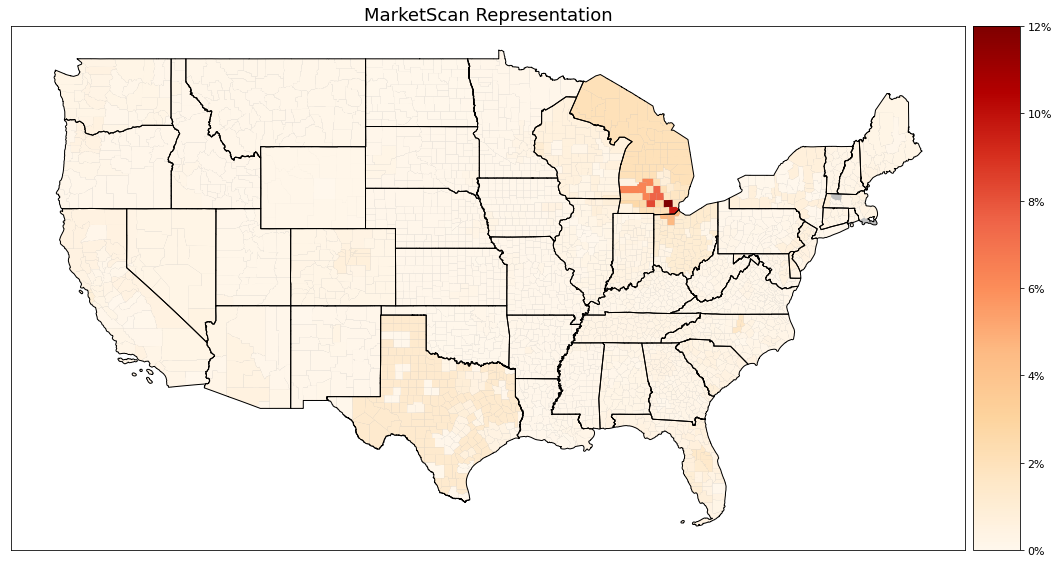

In [192]:
fig, ax = plt.subplots(1,1,figsize=(15,17 * 3.5/7.5))

state_shapes.plot(color = 'gray', alpha=0.5, ax=ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

df_temp.plot(column='representation_medi',
             cmap='OrRd',
             legend=True,
                vmin = 0,
                vmax = 12,
                ax=ax,
                cax=cax)


state_shapes.boundary.plot(color='k', ax=ax, linewidth= 1)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
    
ax.set_title('MarketScan Representation', fontsize=18)
    
cax.tick_params(labelsize=11)
cax.set_yticks([0, 2, 4, 6, 8, 10, 12])
cax.set_yticklabels(['0%', '2%', '4%', '6%', '8%', '10%', '12%'])


plt.tight_layout()
plt.savefig('map_MS.jpg', dpi=200)


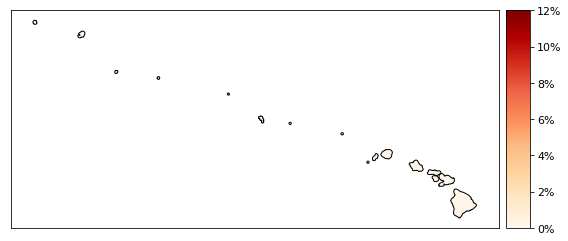

In [193]:
state = us.states.HI

state_shapes_o = gpd.read_file(state.shapefile_urls('state'))
county_shapes_o = gpd.read_file(state.shapefile_urls('county')) 

county_shapes_o['FIPS State Code'] = county_shapes_o.STATEFP10.astype(int)
county_shapes_o['FIPS County Code'] = county_shapes_o.COUNTYFP10.astype(int)
df_temp = pd.merge(county_shapes_o[['FIPS State Code', 'FIPS County Code', 'geometry']],df_rolldown, on=['FIPS State Code', 'FIPS County Code'])

df_temp = df_temp.to_crs(epsg=3857)
state_shapes_o = state_shapes_o.to_crs(epsg=3857)

df_temp['representation_comm'] = 100 * df_temp.coverage_comm
df_temp['representation_medi'] = 100 * df_temp.coverage_medi



fig, ax = plt.subplots(1,1,figsize=(8,8))

state_shapes_o.plot(color = 'gray', alpha=0.5, ax=ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

df_temp.plot(column='representation_medi',
             cmap='OrRd',
                legend=True,
                vmin = 0,
                vmax = 12,
                ax=ax,
                cax=cax)

#county_shape.boundary.plot(color='k', ax=ax, linewidth= 0.5)
state_shapes_o.boundary.plot(color='k', ax=ax, linewidth= 1)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

cax.set_yticks([0, 2, 4, 6, 8, 10, 12])
cax.set_yticklabels(['0%', '2%', '4%', '6%', '8%', '10%', '12%'])
    
ax.set_title('', fontsize=18)
    
cax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('map_HI_MS.jpg', dpi=200)



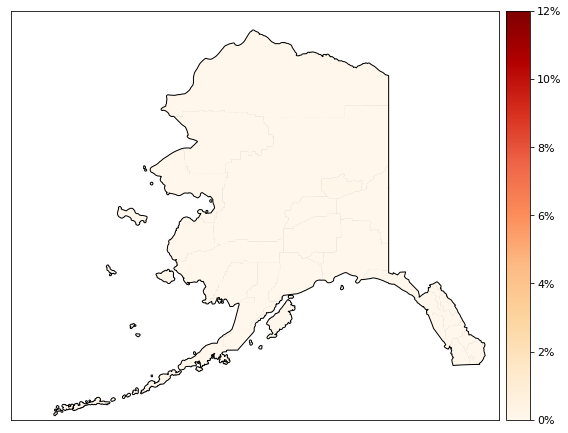

In [194]:
state = us.states.AK

state_shapes_o = gpd.read_file(state.shapefile_urls('state'))
county_shapes_o = gpd.read_file(state.shapefile_urls('county')) 

county_shapes_o['FIPS State Code'] = county_shapes_o.STATEFP10.astype(int)
county_shapes_o['FIPS County Code'] = county_shapes_o.COUNTYFP10.astype(int)
df_temp = pd.merge(county_shapes_o[['FIPS State Code', 'FIPS County Code', 'geometry']],df_rolldown, on=['FIPS State Code', 'FIPS County Code'])

df_temp = df_temp.to_crs(epsg=3857)
state_shapes_o = state_shapes_o.to_crs(epsg=3857)

df_temp['representation_comm'] = 100 * df_temp.coverage_comm
df_temp['representation_medi'] = 100 * df_temp.coverage_medi




fig, ax = plt.subplots(1,1,figsize=(8,8))

state_shapes_o.plot(color = 'gray', alpha=0.5, ax=ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

df_temp.plot(column='representation_medi',
             cmap='OrRd',
                legend=True,
                vmin = 0,
                vmax = 12,
                ax=ax,
                cax=cax)

#county_shape.boundary.plot(color='k', ax=ax, linewidth= 0.5)
state_shapes_o.boundary.plot(color='k', ax=ax, linewidth= 1)


ax.set_xlim([-2.05e7, -1.43e7])
ax.set_ylim([6.6e6, 11.8e6])

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

cax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

cax.set_yticks([0, 2, 4, 6, 8, 10, 12])
cax.set_yticklabels(['0%', '2%', '4%', '6%', '8%', '10%', '12%'])
    
ax.set_title('', fontsize=18)
    
cax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('map_AK_MS.jpg', dpi=200)

In [ ]:
#figuring out the 1 situations

In [278]:
df_ms[df_ms.EGEOLOC==1].mem_days_medi.sum()/df_ms.mem_days_medi.sum() * 100

46.17259455894648

In [280]:
df_ms[(df_ms.EGEOLOC!=1) & (df_ms.MSA.isna())].mem_days_medi.sum() /df_ms.mem_days_medi.sum() * 100

16.72246409736535

In [282]:
df_ms[df_ms.EGEOLOC==1].groupby('MSA').mem_days_medi.sum()

MSA
0.0        19364446.0
10380.0         396.0
11244.0        8064.0
11460.0     1615782.0
11500.0         365.0
              ...    
48864.0           0.0
48900.0        6175.0
49180.0        6813.0
49340.0        5536.0
49420.0        2190.0
Name: mem_days_medi, Length: 149, dtype: float64

In [283]:
19364446.0/df_ms.mem_days_medi.sum() * 100

9.154530373882332